# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [1]:
# Import libraries

import warnings
warnings.filterwarnings("ignore")

# Basic numerical and data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and model evaluation libraries from Scikit-learn
from sklearn.model_selection import train_test_split  # to split data
from sklearn.preprocessing import MinMaxScaler       # for scaling features
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score   # Evaluation metrics

# TensorFlow and Keras for building RNN models
import tensorflow as tf
from tensorflow.keras.models import Sequential  # Sequential API for model building
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Dropout  # RNN layers and utilities
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

# Operating system library for handling file paths
import os



### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [2]:
# Define a function to load data and aggregate them

# List of companies and their corresponding file names
file_list = [
    "RNN_Stocks_Data\\AMZN_stocks_data.csv",
    "RNN_Stocks_Data\\GOOGL_stocks_data.csv",
    "RNN_Stocks_Data\\IBM_stocks_data.csv",
    "RNN_Stocks_Data\\MSFT_stocks_data.csv"
]

def load_and_combine_stock_data(file_list):
    all_data = []

    for file in file_list:
        # Extract stock name from filename (e.g., "AMZN_stock_data.csv" → "AMZN")
        stock_name = os.path.basename(file).split("_")[0]
        print(f"Loading data for {stock_name} from {file}")

        # Load CSV into DataFrame
        df = pd.read_csv(file)

        # Add stock name column (overwrite the existing 'Name' column for consistency)
        df['Name'] = stock_name

        # Drop unnecessary columns if any (we can keep all, or drop Date/Name if merging later by date)
        # You may choose to drop 'Date' if using time windows
        all_data.append(df)

    # Combine all DataFrames into one
    combined_df = pd.concat(all_data, ignore_index=True)

    return combined_df

In [3]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

master_df = load_and_combine_stock_data(file_list)
master_df.head

Loading data for AMZN from RNN_Stocks_Data\AMZN_stocks_data.csv
Loading data for GOOGL from RNN_Stocks_Data\GOOGL_stocks_data.csv
Loading data for IBM from RNN_Stocks_Data\IBM_stocks_data.csv
Loading data for MSFT from RNN_Stocks_Data\MSFT_stocks_data.csv


<bound method NDFrame.head of              Date   Open   High    Low  Close    Volume  Name
0      2006-01-03  47.47  47.85  46.25  47.58   7582127  AMZN
1      2006-01-04  47.48  47.73  46.69  47.25   7440914  AMZN
2      2006-01-05  47.16  48.20  47.11  47.65   5417258  AMZN
3      2006-01-06  47.97  48.58  47.32  47.87   6154285  AMZN
4      2006-01-09  46.55  47.10  46.40  47.08   8945056  AMZN
...           ...    ...    ...    ...    ...       ...   ...
12072  2017-12-22  85.40  85.63  84.92  85.51  14145841  MSFT
12073  2017-12-26  85.31  85.53  85.03  85.40   9891237  MSFT
12074  2017-12-27  85.65  85.98  85.22  85.71  14678025  MSFT
12075  2017-12-28  85.90  85.93  85.55  85.72  10594344  MSFT
12076  2017-12-29  85.63  86.05  85.50  85.54  18717406  MSFT

[12077 rows x 7 columns]>

In [4]:
# View specifics of the data

master_df.shape

(12077, 7)

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [5]:
# Handle Missing Values

print("Record count before dropping missing values:", len(master_df))
print("Missing values per column before dropping:\n", master_df.isnull().sum())

master_df = master_df.dropna()

print("Record count after dropping missing values:", len(master_df))
print("Missing values per column after dropping:\n", master_df.isnull().sum())

Record count before dropping missing values: 12077
Missing values per column before dropping:
 Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64
Record count after dropping missing values: 12076
Missing values per column after dropping:
 Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


In [6]:
# Sort records by date
master_df['Date'] = pd.to_datetime(master_df['Date'], errors='coerce')
print(f"Number of records with NaN or invalid dates: {master_df['Date'].isna().sum()}")

Number of records with NaN or invalid dates: 0


In [7]:
# Year' column for grouping
master_df['Year'] = master_df['Date'].dt.year
master_df.head()

,Date,Open,High,Low,Close,Volume,Name,Year
0,2006-01-03,47.47,47.85,46.25,47.58,7582127,AMZN,2006
1,2006-01-04,47.48,47.73,46.69,47.25,7440914,AMZN,2006
2,2006-01-05,47.16,48.20,47.11,47.65,5417258,AMZN,2006
3,2006-01-06,47.97,48.58,47.32,47.87,6154285,AMZN,2006
4,2006-01-09,46.55,47.10,46.40,47.08,8945056,AMZN,2006


In [8]:
# Month' column for grouping
master_df['Month'] = master_df['Date'].dt.strftime('%B')  # Extracts full month name (e.g., January, February)
print(master_df.head())

        Date   Open   High    Low  Close   Volume  Name  Year    Month
0 2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN  2006  January
1 2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN  2006  January
2 2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN  2006  January
3 2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN  2006  January
4 2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN  2006  January


In [9]:
master_df['Date'].describe()

count                            12076
mean     2012-01-01 14:41:13.136800256
min                2006-01-03 00:00:00
25%                2008-12-31 00:00:00
50%                2011-12-30 00:00:00
75%                2014-12-31 12:00:00
max                2017-12-29 00:00:00
Name: Date, dtype: object

In [10]:
master_df = master_df.sort_values('Date').reset_index(drop=True)
# Display the first few rows of the combined DataFrame
print(f"{master_df.sort_values(by='Date', ascending=False).head()}")

            Date     Open     High      Low    Close    Volume   Name  Year  \
12075 2017-12-29    85.63    86.05    85.50    85.54  18717406   MSFT  2017   
12074 2017-12-29   154.17   154.72   153.42   153.42   3327087    IBM  2017   
12073 2017-12-29  1182.35  1184.00  1167.50  1169.47   2688391   AMZN  2017   
12072 2017-12-29  1055.49  1058.05  1052.70  1053.40   1180340  GOOGL  2017   
12071 2017-12-28  1189.00  1190.10  1184.38  1186.10   1841676   AMZN  2017   

          Month  
12075  December  
12074  December  
12073  December  
12072  December  
12071  December  


In [11]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12076 entries, 0 to 12075
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12076 non-null  datetime64[ns]
 1   Open    12076 non-null  float64       
 2   High    12076 non-null  float64       
 3   Low     12076 non-null  float64       
 4   Close   12076 non-null  float64       
 5   Volume  12076 non-null  int64         
 6   Name    12076 non-null  object        
 7   Year    12076 non-null  int32         
 8   Month   12076 non-null  object        
dtypes: datetime64[ns](1), float64(4), int32(1), int64(1), object(2)
memory usage: 802.1+ KB


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

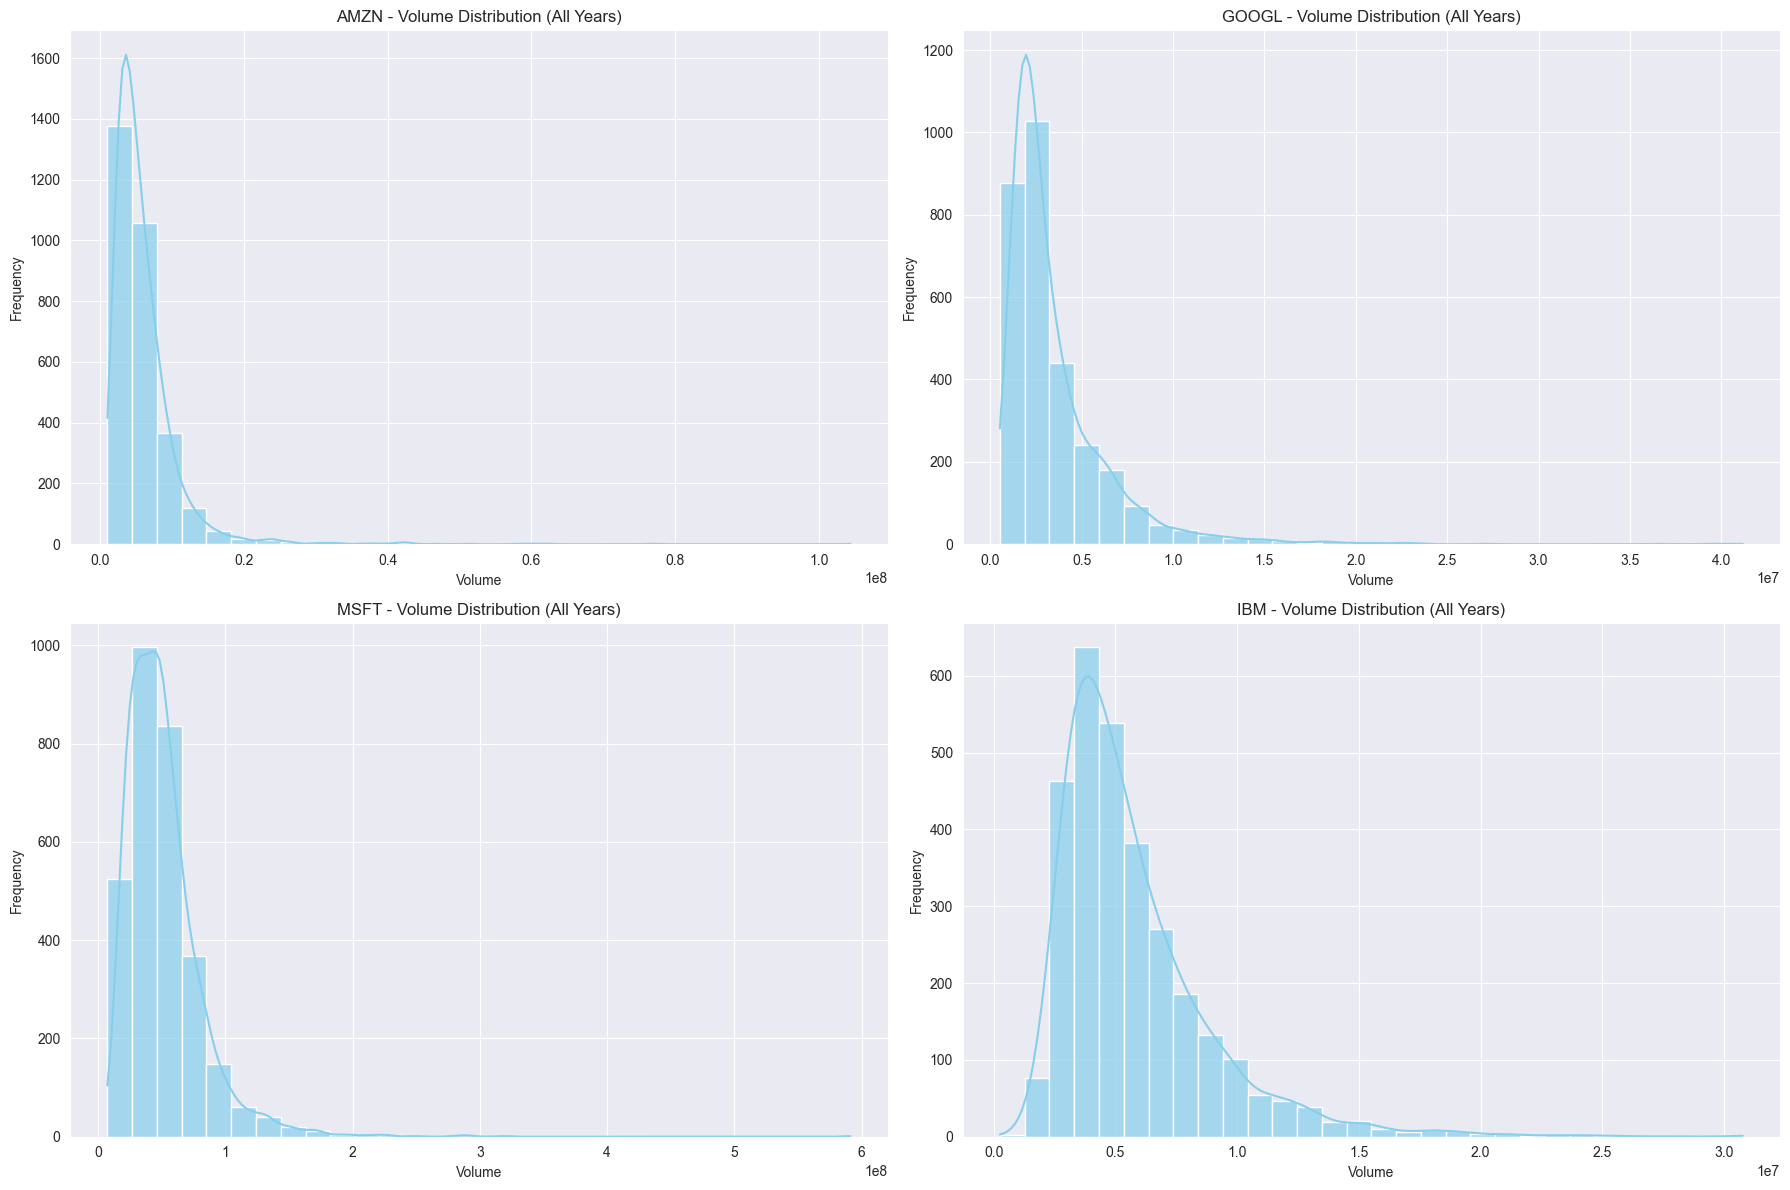

In [12]:
# Frequency distribution of volumes

companies = master_df['Name'].unique()

plt.figure(figsize=(18, 12))
for i, name in enumerate(companies):
    plt.subplot(2, 2, i + 1)
    data = master_df[master_df['Name'] == name]['Volume']
    sns.histplot(data, bins=30, kde=True, color='skyblue', alpha=0.7)
    plt.title(f'{name} - Volume Distribution (All Years)')
    plt.xlabel('Volume')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

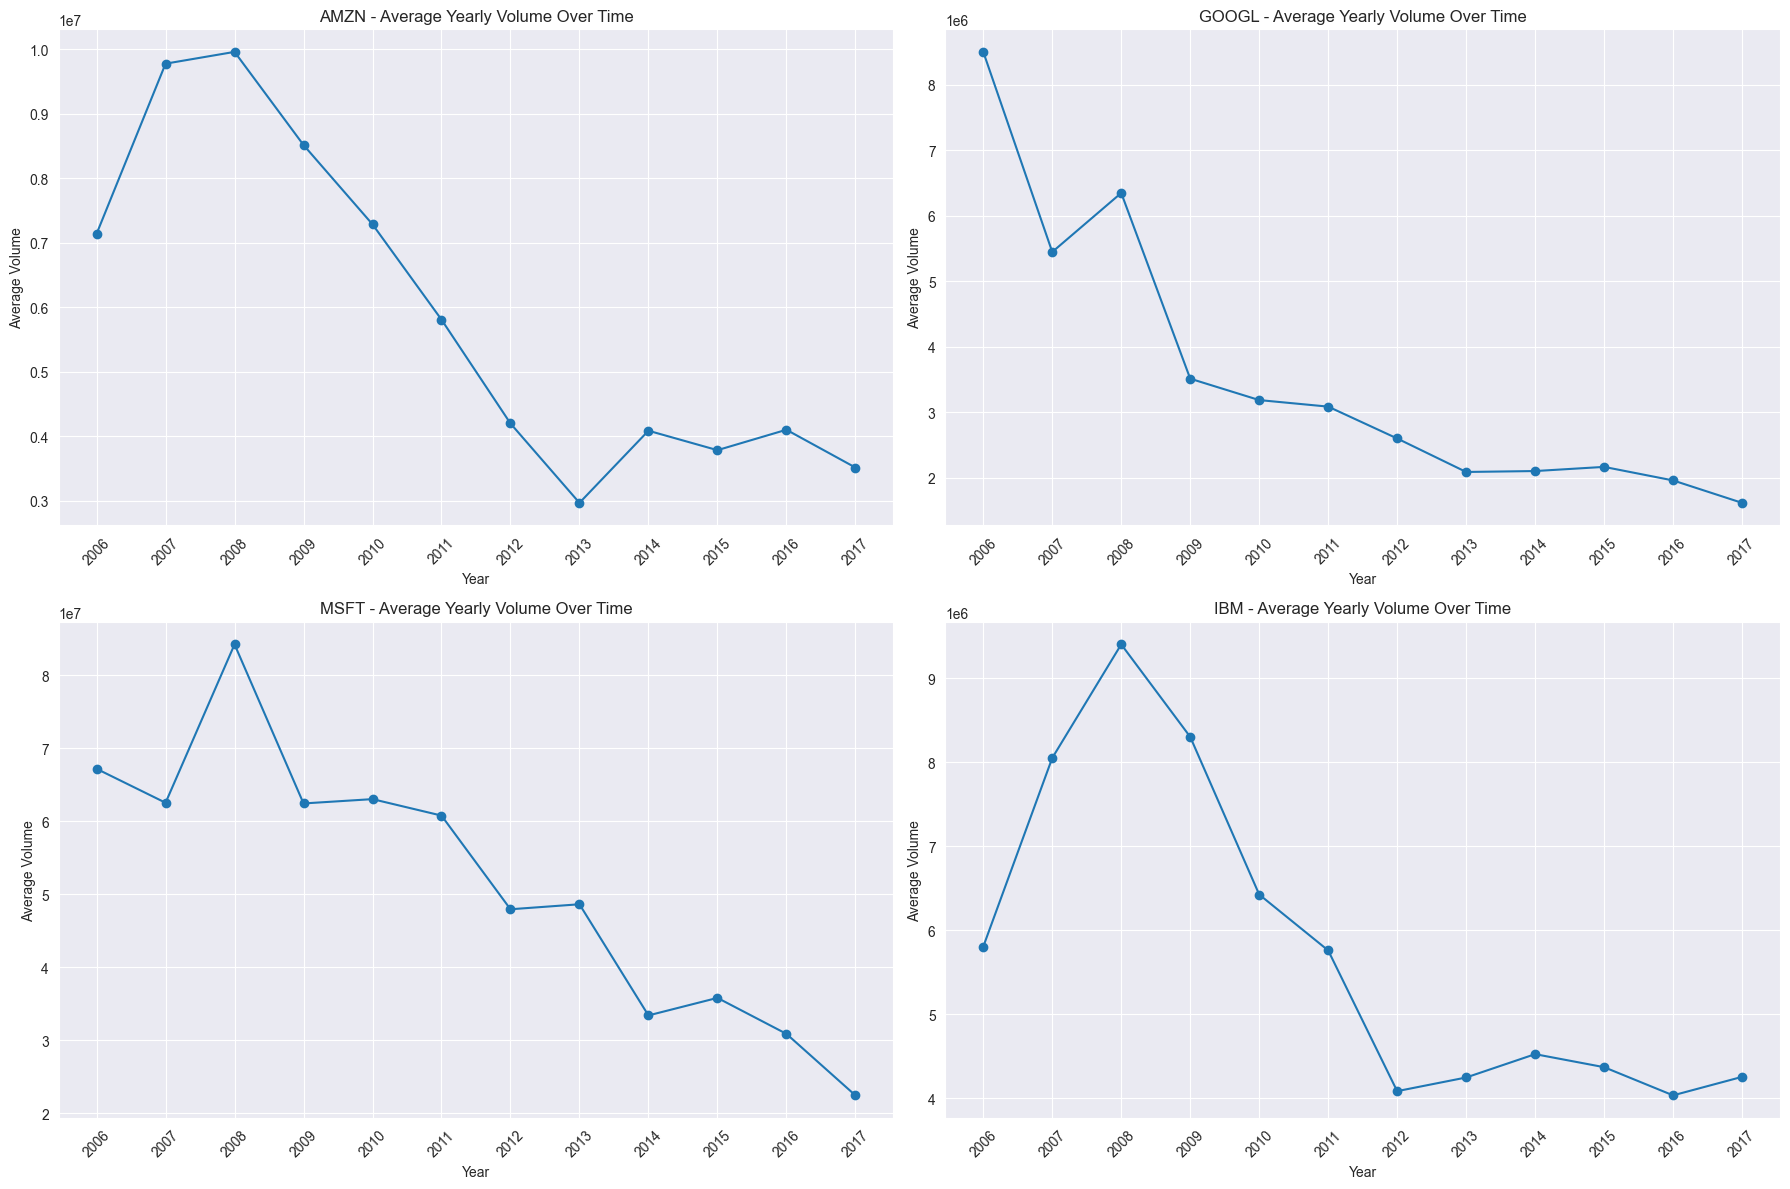

In [13]:
# Stock volume variation over time

master_df['Year'] = master_df['Date'].dt.year

companies = master_df['Name'].unique()
plt.figure(figsize=(18, 12))
for i, name in enumerate(companies):
    plt.subplot(2, 2, i + 1)
    company_yearly = master_df[master_df['Name'] == name].groupby('Year')['Volume'].mean()
    plt.plot(company_yearly.index, company_yearly.values, marker='o')
    plt.title(f'{name} - Average Yearly Volume Over Time')
    plt.xlabel('Year')
    plt.ylabel('Average Volume')
    plt.xticks(company_yearly.index, rotation=45)
plt.tight_layout()
plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [14]:
# Analyse correlations

master_df.describe()

,Date,Open,High,Low,Close,Volume,Year
count,12076,12076.000000,12076.000000,12076.000000,12076.000000,1.207600e+04,12076.000000
mean,2012-01-01 14:41:13.136800256,227.387118,229.429251,225.203189,227.387809,1.671865e+07,2011.499917
min,2006-01-03 00:00:00,15.200000,15.620000,14.870000,15.150000,2.542560e+05,2006.000000
25%,2008-12-31 00:00:00,54.930000,55.660000,54.425000,55.207500,3.124251e+06,2008.000000
50%,2011-12-30 00:00:00,158.795000,160.415000,157.355000,158.890000,5.445861e+06,2011.000000
75%,2014-12-31 12:00:00,281.405000,284.507500,278.610000,281.512500,1.802312e+07,2014.250000
max,2017-12-29 00:00:00,1204.880000,1213.410000,1191.150000,1195.830000,5.910786e+08,2017.000000
std,NaN,236.938260,238.577124,234.981015,236.859712,2.570653e+07,3.451300


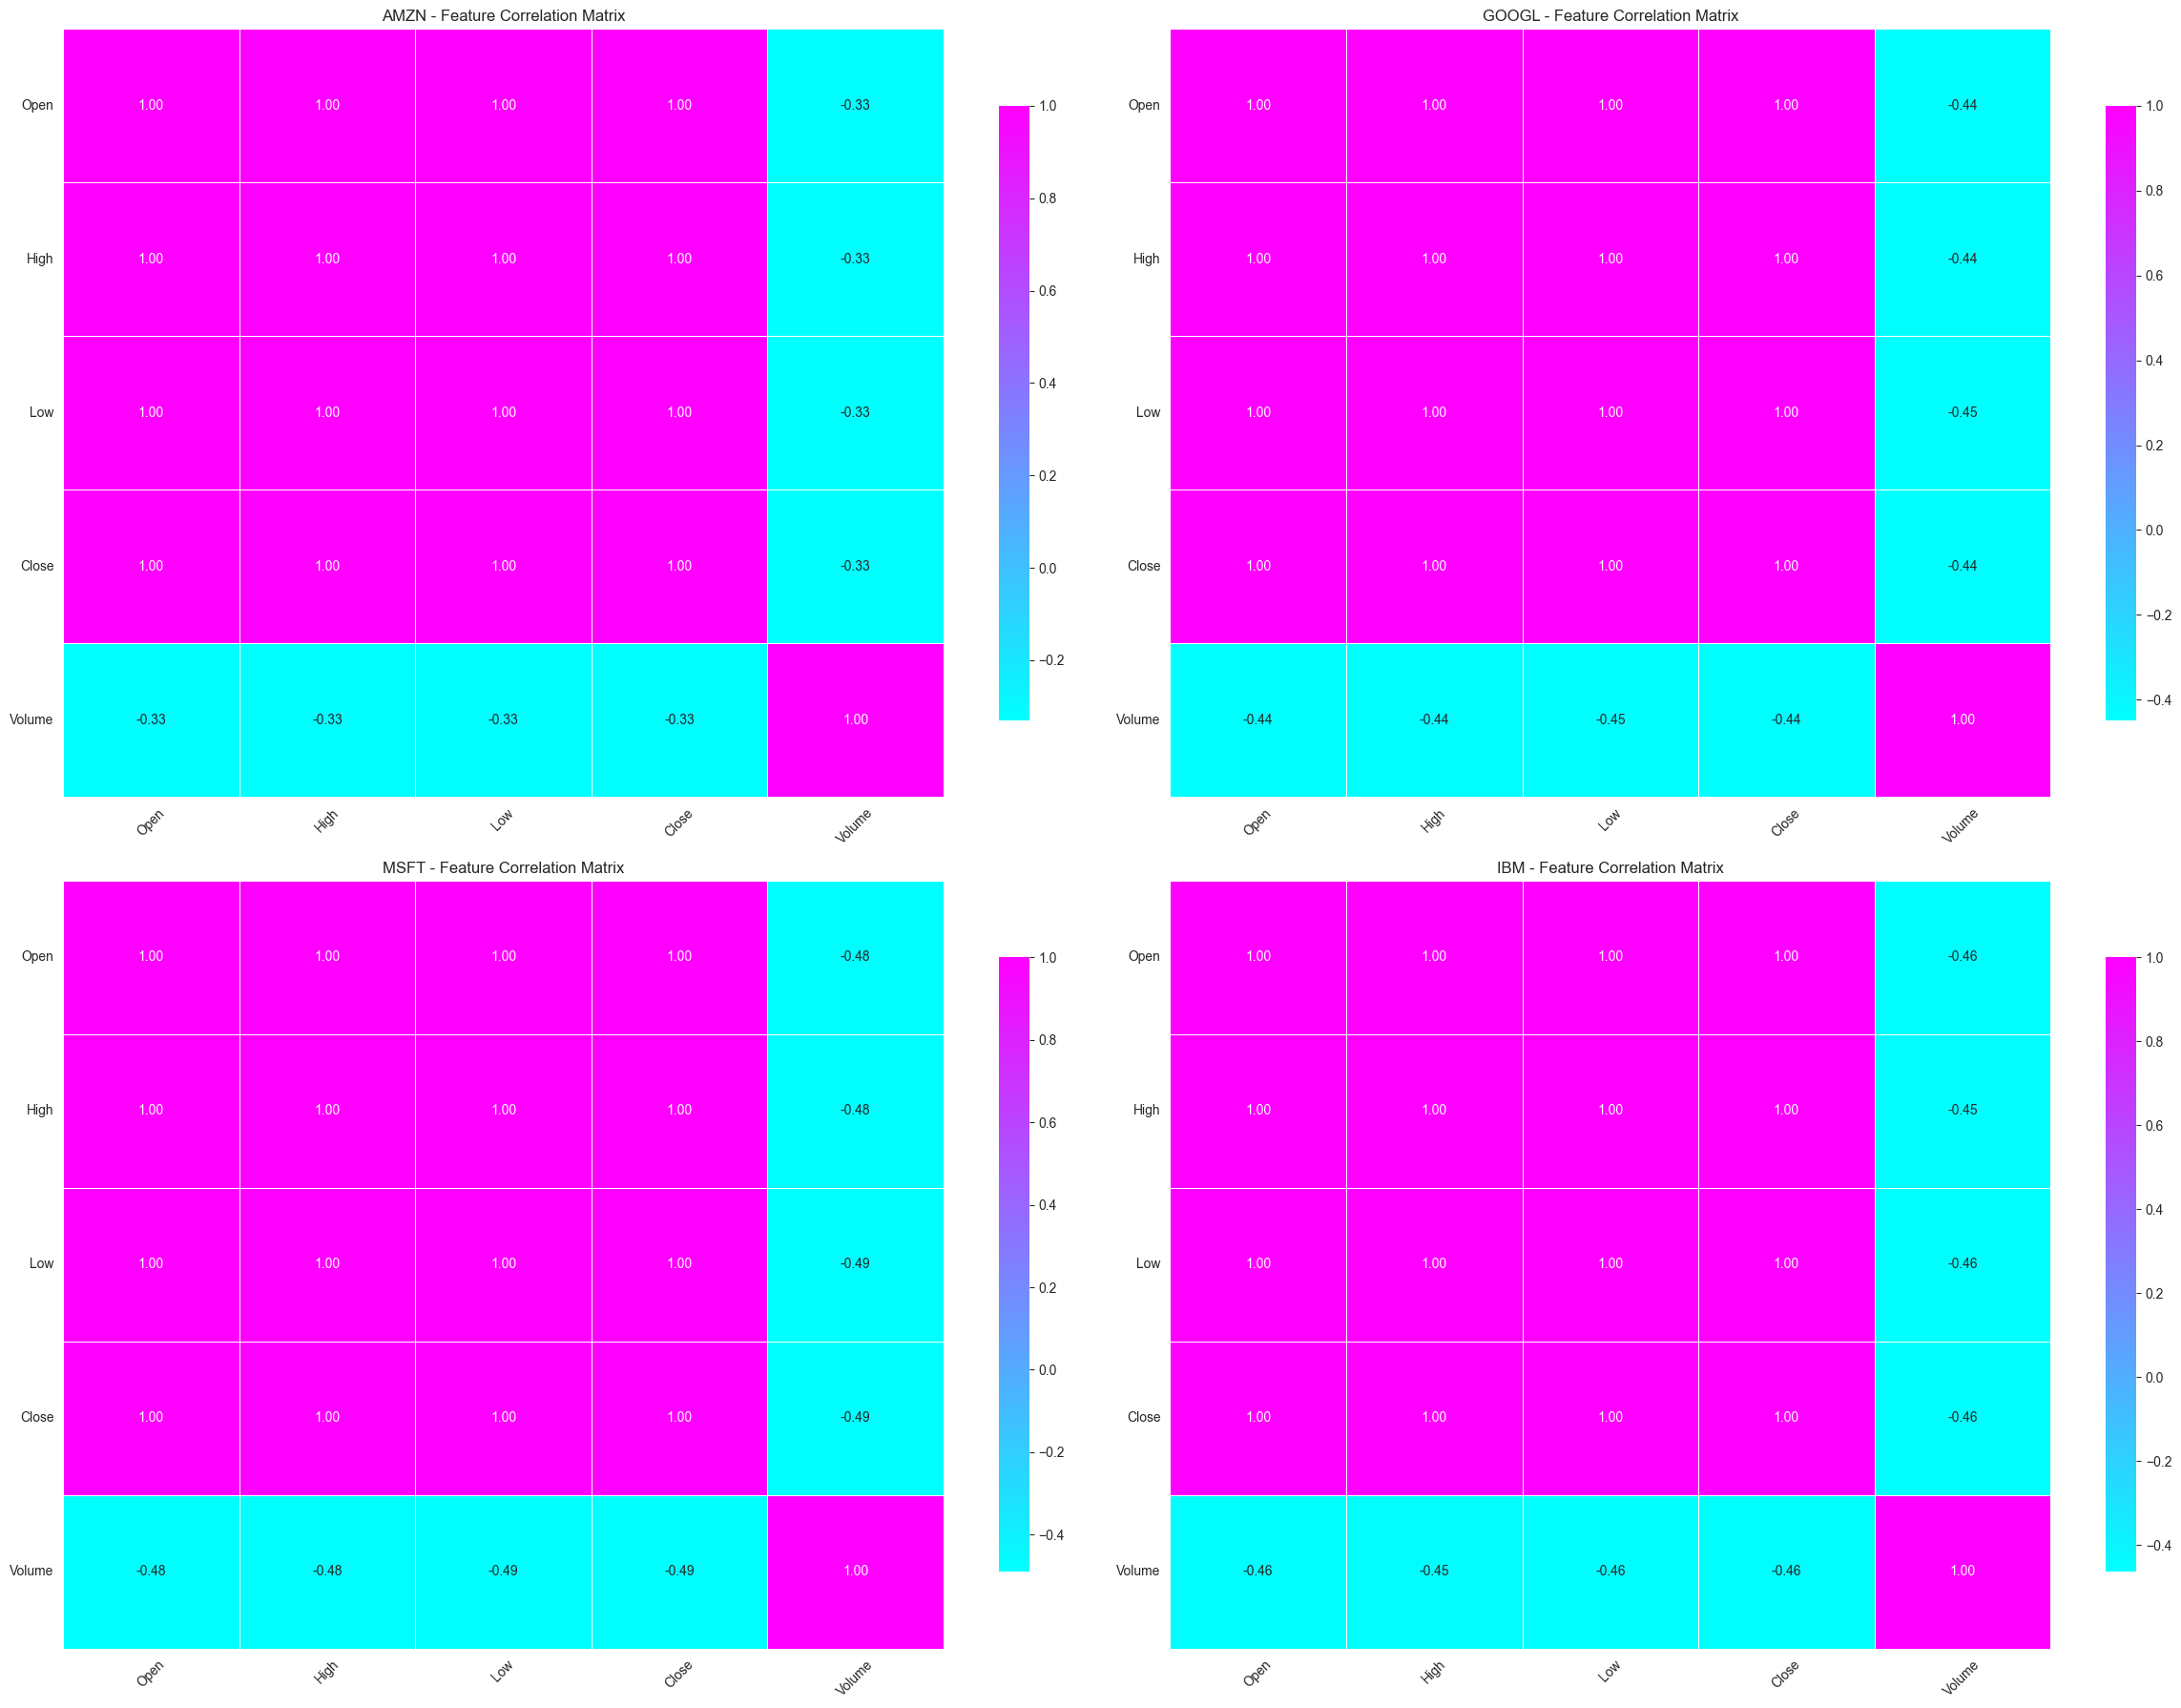

In [15]:
# Analyse correlations

plt.figure(figsize=(24, 18))

for i, company in enumerate(companies):
    company_data = master_df[master_df['Name'] == company][['Open', 'High', 'Low', 'Close', 'Volume']]

    # Compute correlations
    corr_matrix = company_data.corr()

    # Plot heatmap
    plt.subplot(2, 2, i + 1)
    sns.heatmap(corr_matrix, annot=True, cmap='cool', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
    plt.title(f'{company} - Feature Correlation Matrix')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)

plt.tight_layout()
plt.show()


### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [16]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_data(df, target_stocks, window_size=30, step_size=1):
    """
    Create windowed X and y data from the given DataFrame.

    Parameters:
    - df (DataFrame): The input data containing features and target stocks.
    - target_stocks (list): List of stock names whose 'Close' prices are to be predicted.
    - window_size (int): Number of time steps in each window (default=30).
    - step_size (int): Step size for the sliding window (default=1).

    Returns:
    - X_windows (list): List of windowed feature arrays.
    - y (list): List of target values corresponding to each window.
    """
    X_windows = []
    y = []

    # Ensure data is ordered by name and date
    df = df.sort_values(by=['Name', 'Date']).reset_index(drop=True)

    for stock in target_stocks:
        # Filter data for the specific stock
        stock_data = df[df['Name'] == stock].reset_index(drop=True)

        # Select features for the window and the target column
        features = ['Open', 'High', 'Low', 'Close', 'Volume']
        target_col = 'Close'

        for i in range(0, len(stock_data) - window_size, step_size):
            # Create the feature window
            window = stock_data.loc[i:i + window_size - 1, features].values
            # Append the target (next step's closing price)
            target = stock_data.loc[i + window_size, target_col]
            X_windows.append(window)
            y.append(target)

    return X_windows, y

#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [17]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_windowed_data(X_windows, y_values=None):
    """
    Scales the windowed input data and optionally the target data using MinMaxScaler.

    Parameters:
    - X_windows (list or np.array): The windowed feature data (shape: num_samples x window_size x num_features).
    - y_values (list or np.array): Optional target values (shape: num_samples x 1 or num_samples) to scale.

    Returns:
    - X_scaled (np.array): Scaled windowed feature data.
    - y_scaled (np.array or None): Scaled target data (if provided).
    - scaler_X (MinMaxScaler): Scaler object for input data.
    - scaler_y (MinMaxScaler or None): Scaler object for target data (if provided).
    """
    # Convert X_windows to a 2D array (combine windows and features into rows) for scaling
    num_samples, window_size, num_features = np.array(X_windows).shape
    X_reshaped = np.array(X_windows).reshape(-1, num_features)

    # Initialize and fit the scaler for X
    scaler_X = MinMaxScaler()
    X_scaled_reshaped = scaler_X.fit_transform(X_reshaped)  # Scale the reshaped input
    X_scaled = X_scaled_reshaped.reshape(num_samples, window_size, num_features)  # Reshape back to the original structure

    # Initialize and scale y_values if provided
    if y_values is not None:
        y_values = np.array(y_values).reshape(-1, 1)  # Reshape y_values to 2D
        scaler_y = MinMaxScaler()
        y_scaled = scaler_y.fit_transform(y_values)  # Scale the target values
        return X_scaled, y_scaled, scaler_X, scaler_y
    else:
        return X_scaled, None, scaler_X, None

    Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [18]:
# Define a function to create input and output data points from the master DataFrame

def prepare_rnn_data(
    df,
    target_stocks,
    window_size=60,
    window_stride=1,
    split_ratio=0.8
):
    """
    Prepare scaled and windowed data for RNN models from master_df.

    Parameters:
    - df (pd.DataFrame): Master dataset containing stock data with shared columns (Open, High, etc.) and a 'Name' column for stock names.
    - target_stocks (list): List of stock symbols to process (e.g., ['AMZN', 'GOOGL']).
    - window_size (int): Number of past days to include in each window.
    - window_stride (int): Step size between windows (stride).
    - split_ratio (float): Ratio of data to allocate for training (rest will be used for testing).

    Returns:
    - Dictionary with keys as stock symbols and values containing:
        - 'X_train', 'y_train', 'X_test', 'y_test': Scaled data for each stock.
        - 'scaler_X', 'scaler_y': Scalers for inputs and outputs.
    """
    rnn_data = {}

    for stock in target_stocks:
        print(f"Preparing data for stock: {stock}...")

        # Step 1: Filter the DataFrame for the current stock
        stock_df = df[df["Name"] == stock].copy().reset_index(drop=True)

        # Step 2: Extract feature and target columns
        feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume']  # Shared column names
        target_col = ['Close']  # Target is the closing price

        data = stock_df[feature_cols].values  # Extract feature values
        target = stock_df[target_col].values  # Extract target values

        # Step 3: Create windows (X) and targets (y)
        X, y = [], []
        for i in range(0, len(data) - window_size, window_stride):
            # Create a window for input features and the corresponding target
            X.append(data[i:i + window_size])
            y.append(target[i + window_size])
        X, y = np.array(X), np.array(y).reshape(-1, 1)  # Ensure y is 2D for scaling

        # Step 4: Train-test split for X and y
        split_index = int(split_ratio * len(X))
        X_train, X_test = X[:split_index], X[split_index:]
        y_train, y_test = y[:split_index], y[split_index:]

        # Step 5: Scale features and targets
        scaler_X = MinMaxScaler()
        X_train_reshaped = X_train.reshape(-1, X_train.shape[2])  # Collapse time steps for scaling
        X_test_reshaped = X_test.reshape(-1, X_test.shape[2])

        X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(X_train.shape)
        X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape)

        scaler_y = MinMaxScaler()
        y_train_scaled = scaler_y.fit_transform(y_train)
        y_test_scaled = scaler_y.transform(y_test)

        # Step 6: Save results in the dictionary
        rnn_data[stock] = {
            'X_train': X_train_scaled,
            'y_train': y_train_scaled,
            'X_test': X_test_scaled,
            'y_test': y_test_scaled,
            'scaler_X': scaler_X,
            'scaler_y': scaler_y,
            'features': feature_cols,
            'target': target_col[0]
        }

    return rnn_data


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

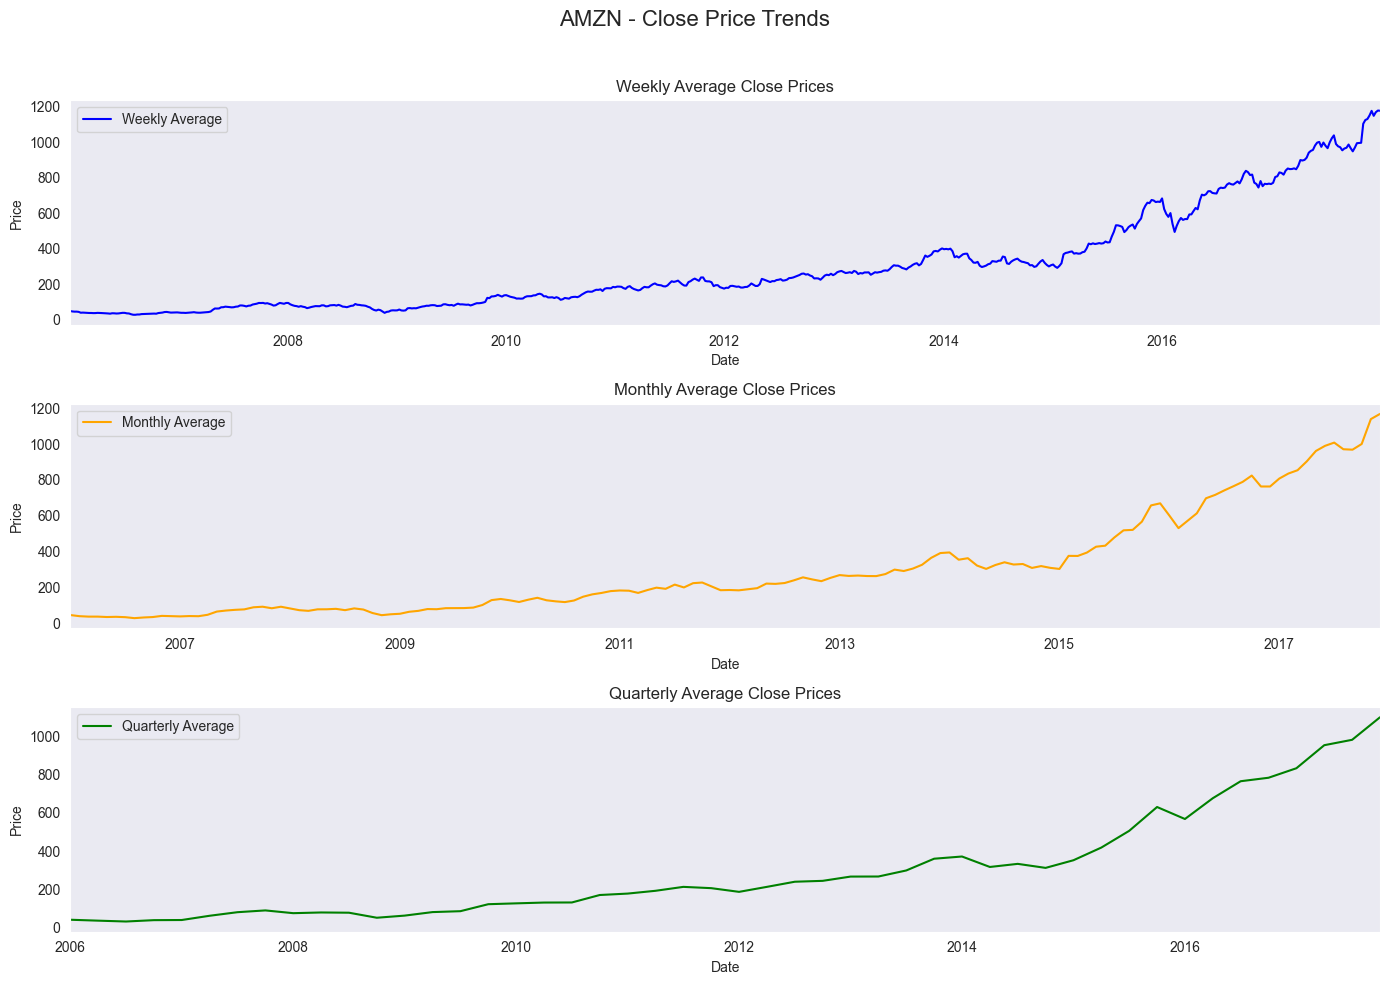

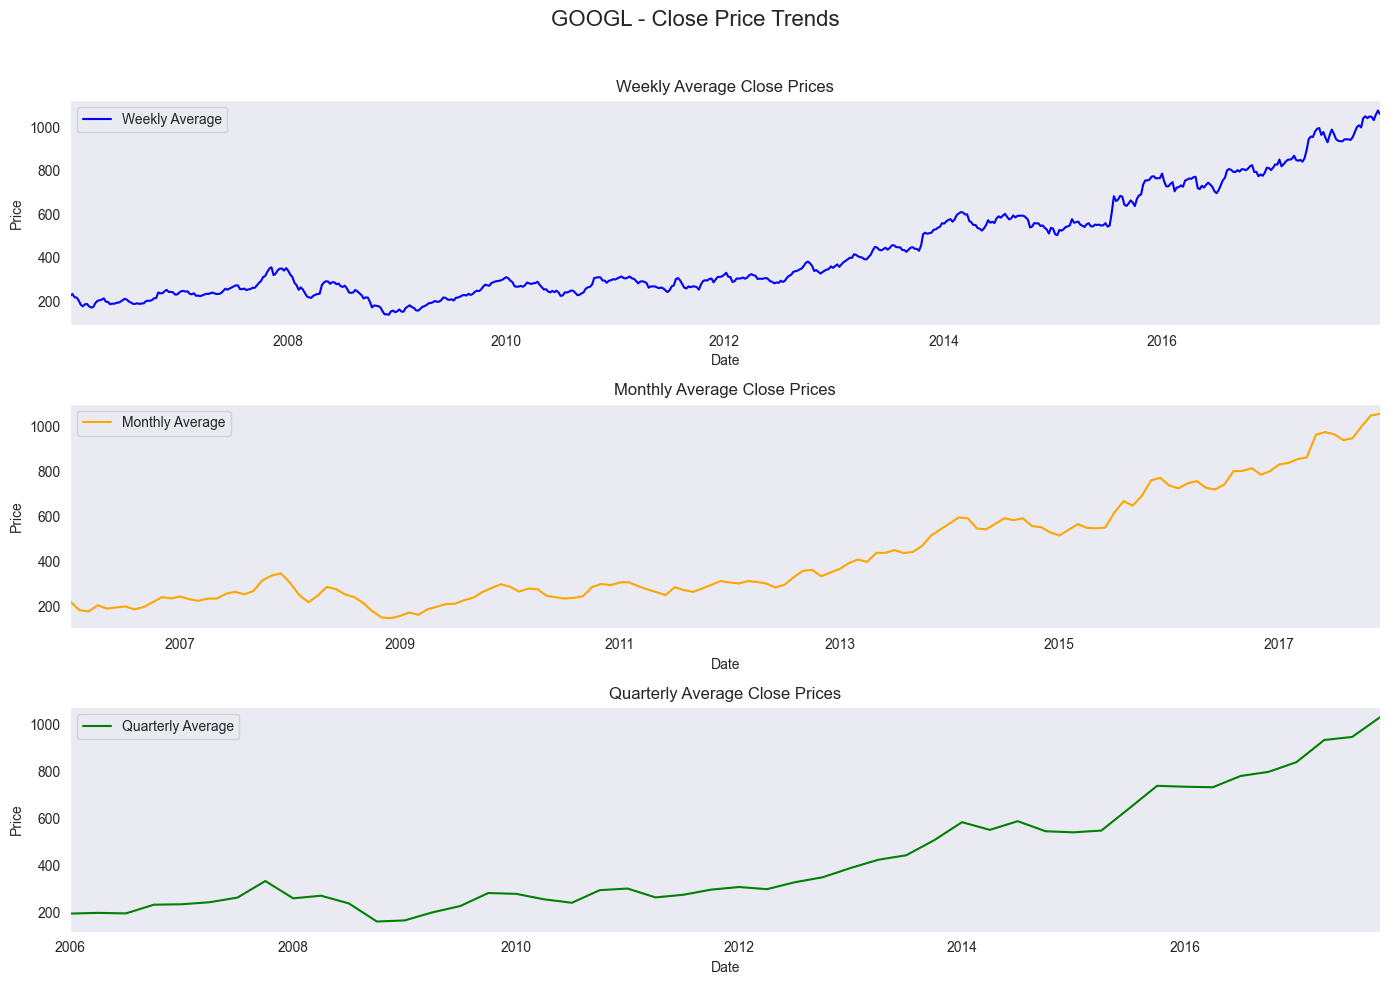

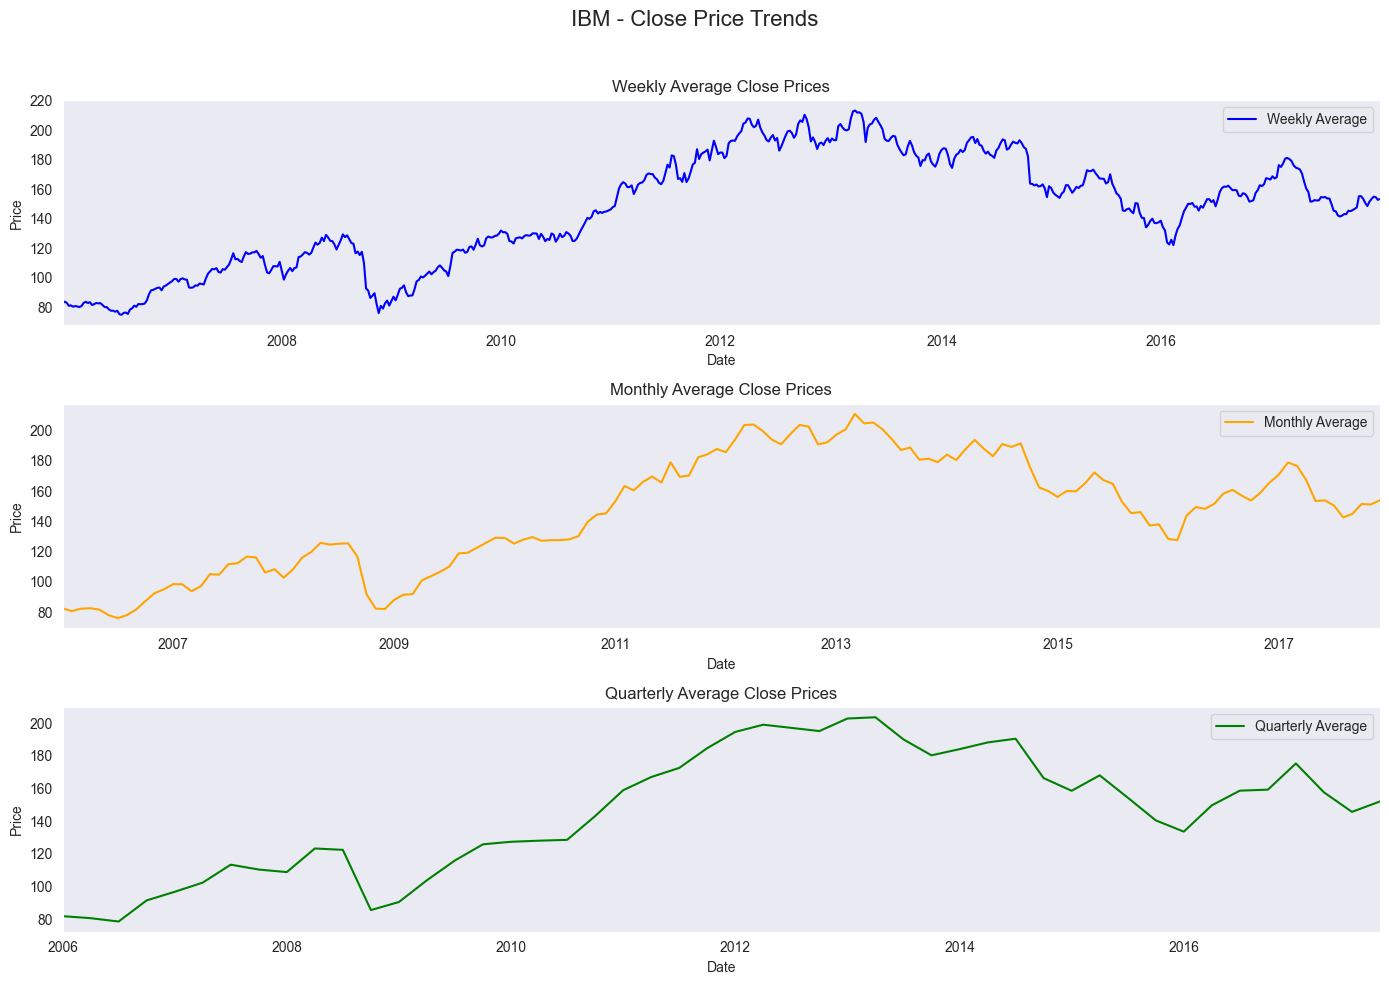

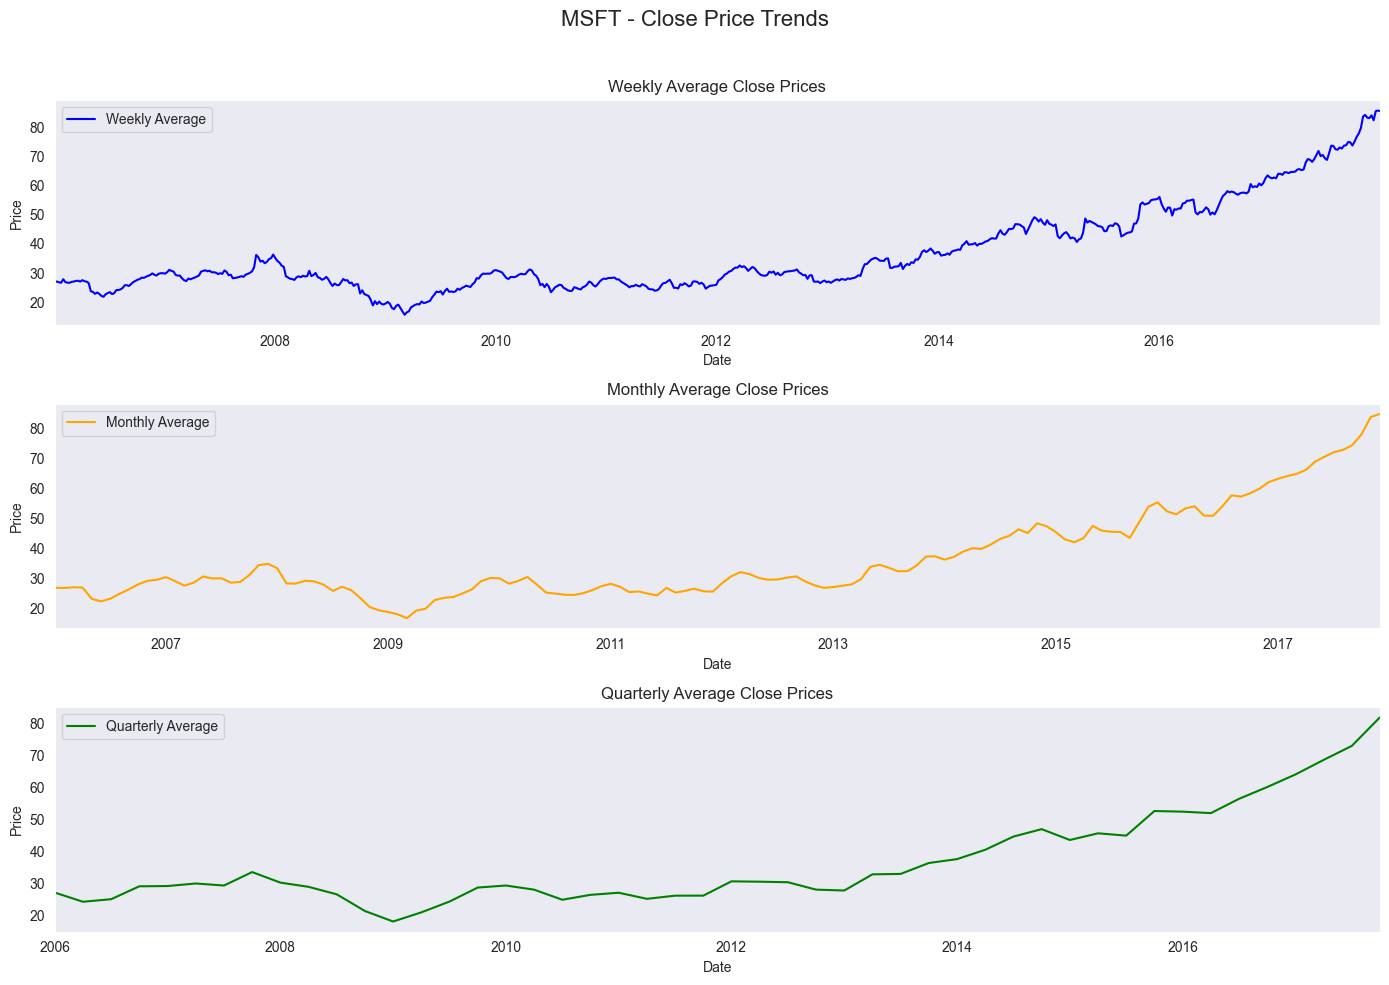

In [19]:
# Checking for patterns in different sequence lengths

def analyze_window_size(data, stock_names):
    """
    Analyze suitable window sizes by visualizing stock price trends for different time groupings.

    Parameters:
    - data (DataFrame): Cleaned DataFrame containing stock data including 'Date', 'Name', and 'Close'.
    - stock_names (list): List of stock names to visualize.
    """
    # Ensure the 'Date' column is in datetime format and sorted
    data['Date'] = pd.to_datetime(data['Date'])
    data = data.sort_values(by='Date')

    # Set Date as the index for resampling
    data.set_index('Date', inplace=True)

    for stock in stock_names:
        # Filter data for the current stock
        stock_data = data[data['Name'] == stock]

        # Resample the data to Weekly, Monthly, and Quarterly frequencies
        weekly = stock_data['Close'].resample('W').mean()
        monthly = stock_data['Close'].resample('M').mean()
        quarterly = stock_data['Close'].resample('Q').mean()

        # Plot
        plt.figure(figsize=(14, 10))
        plt.suptitle(f'{stock} - Close Price Trends', fontsize=16)

        # Weekly
        plt.subplot(3, 1, 1)
        weekly.plot(color='blue', label='Weekly Average')
        plt.title('Weekly Average Close Prices')
        plt.ylabel('Price')
        plt.grid()
        plt.legend()

        # Monthly
        plt.subplot(3, 1, 2)
        monthly.plot(color='orange', label='Monthly Average')
        plt.title('Monthly Average Close Prices')
        plt.ylabel('Price')
        plt.grid()
        plt.legend()

        # Quarterly
        plt.subplot(3, 1, 3)
        quarterly.plot(color='green', label='Quarterly Average')
        plt.title('Quarterly Average Close Prices')
        plt.ylabel('Price')
        plt.xlabel('Date')
        plt.grid()
        plt.legend()

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

stock_names = ['AMZN', 'GOOGL', 'IBM', 'MSFT']
analyze_window_size(data=master_df, stock_names=stock_names)


#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [20]:
# Create data instances from the master data frame using decided window size and window stride

target_stocks = ['AMZN', 'GOOGL', 'IBM', 'MSFT']

# Prepare the RNN data
rnn_data = prepare_rnn_data(
    df=master_df,          # Master DataFrame
    target_stocks=target_stocks,  # List of stocks to process
    window_size=60,        # Sliding window size
    window_stride=1,       # Step size for window creation
    split_ratio=0.8        # Train-test split ratio
)


Preparing data for stock: AMZN...
Preparing data for stock: GOOGL...
Preparing data for stock: IBM...
Preparing data for stock: MSFT...


In [21]:
# Check the number of data points generated

# Access the data for Amazon
amazon_data = rnn_data['AMZN']

print("Amazon X_train:", amazon_data['X_train'].shape)
print("Amazon y_train:", amazon_data['y_train'].shape)
print("Amazon X_test:", amazon_data['X_test'].shape)
print("Amazon y_test:", amazon_data['y_test'].shape)

print("Amazon feature scaler:", amazon_data['scaler_X'])
print("Amazon target scaler:", amazon_data['scaler_y'])

Amazon X_train: (2367, 60, 5)
Amazon y_train: (2367, 1)
Amazon X_test: (592, 60, 5)
Amazon y_test: (592, 1)
Amazon feature scaler: MinMaxScaler()
Amazon target scaler: MinMaxScaler()


In [22]:
# Access the data for Google
google_data = rnn_data['GOOGL']

print("Google X_train:", google_data['X_train'].shape)
print("Google y_train:", google_data['y_train'].shape)
print("Google X_test:", google_data['X_test'].shape)
print("Google y_test:", google_data['y_test'].shape)

print("Google feature scaler:", google_data['scaler_X'])
print("Google target scaler:", google_data['scaler_y'])

Google X_train: (2367, 60, 5)
Google y_train: (2367, 1)
Google X_test: (592, 60, 5)
Google y_test: (592, 1)
Google feature scaler: MinMaxScaler()
Google target scaler: MinMaxScaler()


In [23]:
# Access the data for IBM
ibm_data = rnn_data['IBM']

print("IBM X_train:", ibm_data['X_train'].shape)
print("IBM y_train:", ibm_data['y_train'].shape)
print("IBM X_test:", ibm_data['X_test'].shape)
print("IBM y_test:", ibm_data['y_test'].shape)

print("IBM feature scaler:", ibm_data['scaler_X'])
print("IBM target scaler:", ibm_data['scaler_y'])

IBM X_train: (2367, 60, 5)
IBM y_train: (2367, 1)
IBM X_test: (592, 60, 5)
IBM y_test: (592, 1)
IBM feature scaler: MinMaxScaler()
IBM target scaler: MinMaxScaler()


In [24]:
# Access the data for Microsoft
msoft_data = rnn_data['MSFT']

print("Microsoft X_train:", msoft_data['X_train'].shape)
print("Microsoft y_train:", msoft_data['y_train'].shape)
print("Microsoft X_test:", msoft_data['X_test'].shape)
print("Microsoft y_test:", msoft_data['y_test'].shape)

print("Microsoft feature scaler:", msoft_data['scaler_X'])
print("Microsoft target scaler:", msoft_data['scaler_y'])

Microsoft X_train: (2367, 60, 5)
Microsoft y_train: (2367, 1)
Microsoft X_test: (592, 60, 5)
Microsoft y_test: (592, 1)
Microsoft feature scaler: MinMaxScaler()
Microsoft target scaler: MinMaxScaler()


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [27]:
# Check if the datasets are compatible inputs to neural networks

def validate_rnn_data(stocks_data):
    """
    Validate the format of training and testing datasets for RNN models.

    Parameters:
    - stocks_data (dict): Dictionary containing RNN data for multiple stocks.

    Prints validation results for each stock.
    """
    for stock_name, data in stocks_data.items():
        print(f"\n==== Validation Results for {stock_name} ====")

        # Check shapes of the datasets
        X_train_shape = data['X_train'].shape
        X_test_shape = data['X_test'].shape
        y_train_shape = data['y_train'].shape
        y_test_shape = data['y_test'].shape

        print(f"X_train shape: {X_train_shape}, X_test shape: {X_test_shape}")
        print(f"y_train shape: {y_train_shape}, y_test shape: {y_test_shape}")

        # Check dataset dimensionality
        if len(X_train_shape) != 3 or len(X_test_shape) != 3:
            print(f"ERROR: X_train or X_test for {stock_name} is not 3D!")
        if len(y_train_shape) != 2 or len(y_test_shape) != 2:
            print(f"ERROR: y_train or y_test for {stock_name} is not 2D!")

        # Check for NaN or missing values
        if np.any(np.isnan(data['X_train'])) or np.any(np.isnan(data['X_test'])):
            print(f"ERROR: X contains NaN values in {stock_name}!")
        if np.any(np.isnan(data['y_train'])) or np.any(np.isnan(data['y_test'])):
            print(f"ERROR: y contains NaN values in {stock_name}!")

        # Check data types
        if data['X_train'].dtype != 'float32' or data['X_test'].dtype != 'float32':
            print(f"WARNING: X_train or X_test for {stock_name} is not float32!")
            data['X_train'] = data['X_train'].astype('float32')
            data['X_test'] = data['X_test'].astype('float32')
            print(f"INFO: X_train or X_test for {stock_name} is converted to float32!")
        if data['y_train'].dtype != 'float32' or data['y_test'].dtype != 'float32':
            print(f"WARNING: y_train or y_test for {stock_name} is not float32!")
            data['y_train'] = data['y_train'].astype('float32')
            data['y_test'] = data['y_test'].astype('float32')
            print(f"INFO: y_train or y_test for {stock_name} is converted to float32!")

        print("Validation completed.")

# Consolidate the RNN data for all stocks into a dictionary
stocks_data = {
    'MSFT': msoft_data,
    'IBM': ibm_data,
    'AMZN': amazon_data,
    'GOOGL': google_data
}

# Validate the datasets
validate_rnn_data(stocks_data)



==== Validation Results for MSFT ====
X_train shape: (2367, 60, 5), X_test shape: (592, 60, 5)
y_train shape: (2367, 1), y_test shape: (592, 1)
INFO: X_train or X_test for MSFT is converted to float32!
INFO: y_train or y_test for MSFT is converted to float32!
Validation completed.

==== Validation Results for IBM ====
X_train shape: (2367, 60, 5), X_test shape: (592, 60, 5)
y_train shape: (2367, 1), y_test shape: (592, 1)
INFO: X_train or X_test for IBM is converted to float32!
INFO: y_train or y_test for IBM is converted to float32!
Validation completed.

==== Validation Results for AMZN ====
X_train shape: (2367, 60, 5), X_test shape: (592, 60, 5)
y_train shape: (2367, 1), y_test shape: (592, 1)
INFO: X_train or X_test for AMZN is converted to float32!
INFO: y_train or y_test for AMZN is converted to float32!
Validation completed.

==== Validation Results for GOOGL ====
X_train shape: (2367, 60, 5), X_test shape: (592, 60, 5)
y_train shape: (2367, 1), y_test shape: (592, 1)
INFO: X_

In [28]:
validate_rnn_data(stocks_data)


==== Validation Results for MSFT ====
X_train shape: (2367, 60, 5), X_test shape: (592, 60, 5)
y_train shape: (2367, 1), y_test shape: (592, 1)
Validation completed.

==== Validation Results for IBM ====
X_train shape: (2367, 60, 5), X_test shape: (592, 60, 5)
y_train shape: (2367, 1), y_test shape: (592, 1)
Validation completed.

==== Validation Results for AMZN ====
X_train shape: (2367, 60, 5), X_test shape: (592, 60, 5)
y_train shape: (2367, 1), y_test shape: (592, 1)
Validation completed.

==== Validation Results for GOOGL ====
X_train shape: (2367, 60, 5), X_test shape: (592, 60, 5)
y_train shape: (2367, 1), y_test shape: (592, 1)
Validation completed.


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [29]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def create_simple_rnn_model(config, input_shape):
    """
    Creates a simple RNN model based on given configuration arguments.

    Parameters:
    - config (dict): A dictionary containing model configuration parameters. Includes:
        - 'rnn_units' (int): Number of units in the RNN layer.
        - 'dropout' (float): Dropout rate (default is 0.0 if not provided).
        - 'optimizer' (str): Optimizer name (e.g., 'adam', 'rmsprop').
        - 'loss' (str): Loss function (e.g., 'mse', 'mae').
    - input_shape (tuple): Shape of the input data, typically (timesteps, features).

    Returns:
    - model (Sequential): A compiled Keras Sequential model.
    """
    model = Sequential()

    # Add RNN layer
    model.add(SimpleRNN(units=config['rnn_units'], input_shape=input_shape))

    # Add Dropout layer if specified
    if 'dropout' in config and config['dropout'] > 0:
        model.add(Dropout(rate=config['dropout']))

    # Add output layer for regression (1 unit and no activation for linear output)
    model.add(Dense(units=1, activation=None))

    # Compile the model
    optimizer = config.get('optimizer', 'adam')
    if optimizer.lower() == 'adam':
        optimizer = Adam()
    elif optimizer.lower() == 'rmsprop':
        optimizer = RMSprop()

    model.compile(optimizer=optimizer, loss=config['loss'], metrics=['mae'])

    print("Model successfully created and compiled!")
    return model


#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [30]:
# Find an optimal configuration of simple RNN

def tune_simple_rnn(X_train, y_train, input_shape, configs, epochs=20, batch_size=32):
    """
    Tune the simple RNN model with given hyperparameter configurations.

    Parameters:
    - X_train, y_train: Training data
    - input_shape (tuple): Shape of the input data (timesteps, features)
    - configs (list of dict): List of configuration dictionaries to test
    - epochs (int): Number of epochs to train for each configuration
    - batch_size (int): Batch size for training

    Returns:
    - best_config (dict): The configuration with the lowest validation loss
    - best_model (Sequential): Compiled model with the best configuration
    - results (list of dict): Validation loss for all tested configurations
    """
    best_val_loss = float('inf')
    best_config = None
    best_model = None
    results = []

    for i, config in enumerate(configs):
        print(f"\n🔧 Training config {i+1}/{len(configs)}: {config}")

        # Create the model using the given configuration
        model = create_simple_rnn_model(config, input_shape)

        # Train the model
        history = model.fit(
            X_train, y_train,
            validation_split=0.1,  # Use 10% of training data for validation
            epochs=epochs,
            batch_size=batch_size,
            verbose=0  # Suppress training logs
        )

        # Get the final validation loss
        val_loss = history.history['val_loss'][-1]
        print(f"Validation Loss: {val_loss:.4f}")

        # Store the results
        results.append({'config': config, 'val_loss': val_loss})

        # Update best configuration if this one is better
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_config = config
            best_model = model

    print(f"\n✅ Best configuration: {best_config} with Validation Loss: {best_val_loss:.4f}")
    return best_config, best_model, results

configs = [
    {'rnn_units': 32, 'dropout': 0.0, 'optimizer': 'adam', 'loss': 'mse'},
    {'rnn_units': 64, 'dropout': 0.2, 'optimizer': 'adam', 'loss': 'mse'},
    {'rnn_units': 128, 'dropout': 0.3, 'optimizer': 'rmsprop', 'loss': 'mse'},
    {'rnn_units': 64, 'dropout': 0.1, 'optimizer': 'adam', 'loss': 'mae'}
]


In [33]:
# Find the best configuration based on evaluation metrics

input_shape = (60, 5)

# Call the tuning function for MSFT
best_msoft_config, best_msoft_model, results = tune_simple_rnn(
    msoft_data['X_train'], msoft_data['y_train'],
    input_shape,
    configs,
    epochs=20,
    batch_size=32
)



🔧 Training config 1/4: {'rnn_units': 32, 'dropout': 0.0, 'optimizer': 'adam', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0009

🔧 Training config 2/4: {'rnn_units': 64, 'dropout': 0.2, 'optimizer': 'adam', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0006

🔧 Training config 3/4: {'rnn_units': 128, 'dropout': 0.3, 'optimizer': 'rmsprop', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0005

🔧 Training config 4/4: {'rnn_units': 64, 'dropout': 0.1, 'optimizer': 'adam', 'loss': 'mae'}
Model successfully created and compiled!
Validation Loss: 0.0150

✅ Best configuration: {'rnn_units': 128, 'dropout': 0.3, 'optimizer': 'rmsprop', 'loss': 'mse'} with Validation Loss: 0.0005


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [34]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

# Retrain the best model
final_history = best_msoft_model.fit(
    msoft_data['X_train'], msoft_data['y_train'],
    epochs=50,           # Retrain with more epochs if needed
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluate on the test dataset
y_pred_msoft = best_msoft_model.predict(msoft_data['X_test'])


Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 7.6023e-04 - mae: 0.0211 - val_loss: 4.7966e-04 - val_mae: 0.0152
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.8939e-04 - mae: 0.0200 - val_loss: 0.0012 - val_mae: 0.0301
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.5222e-04 - mae: 0.0191 - val_loss: 0.0013 - val_mae: 0.0303
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 8.1501e-04 - mae: 0.0212 - val_loss: 0.0018 - val_mae: 0.0373
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 6.5376e-04 - mae: 0.0191 - val_loss: 6.6899e-04 - val_mae: 0.0193
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 6.5922e-04 - mae: 0.0190 - val_loss: 4.8658e-04 - val_mae: 0.0153
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 7.8885e-04 - mae: 0.0203 - val_loss: 7.3777e-04 - val_mae: 0.0208
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.4456e-04 - mae: 0.0176 - val_loss: 7.7743e-04 - val_mae: 0.0215
Epoch 9/50
67

Plotting the actual vs predicted values

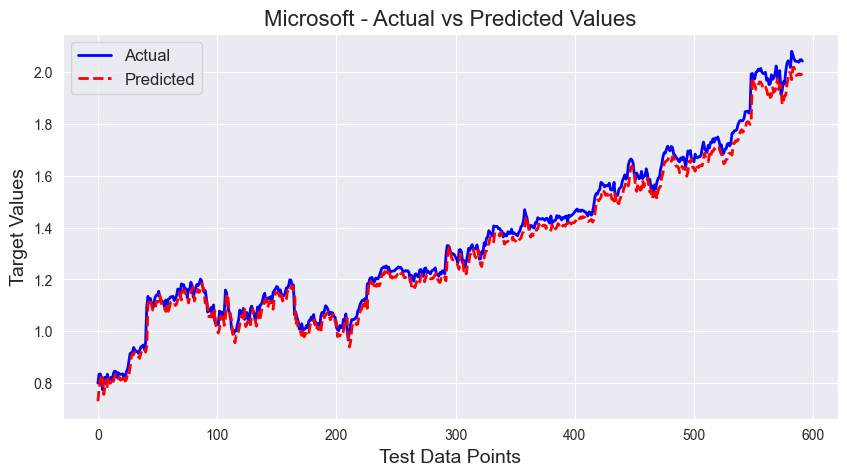

In [37]:
# Predict on the test data and plot

plt.figure(figsize=(10, 5))
plt.plot(msoft_data['y_test'], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_msoft, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Microsoft - Actual vs Predicted Values', fontsize=16)
plt.xlabel('Test Data Points', fontsize=14)
plt.ylabel('Target Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()


- A **large MSE & MAE** on test dataset means predictions with simple RNN are significantly off from the actual values.
- An **R² Score less than 0** (especially as low as -2.4967) means simple RNN model is performing **worse than simply predicting the mean** of your target variable

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [36]:
# Compute the performance of the model on the testing data set

mse_test_msoft = mean_squared_error(msoft_data['y_test'], y_pred_msoft)
mae_test_msoft = mean_absolute_error(msoft_data['y_test'], y_pred_msoft)
r2_test_msoft = r2_score(msoft_data['y_test'], y_pred_msoft)

y_train_pred_msoft = best_model.predict(msoft_data['X_train'])
mse_train_msoft = mean_squared_error(msoft_data['y_train'], y_train_pred_msoft)
mae_train_msoft = mean_absolute_error(msoft_data['y_train'], y_train_pred_msoft)
r2_train_msoft = r2_score(msoft_data['y_train'], y_train_pred_msoft)

print("Test Data Performance:")
print(f"MSE: {mse_test_msoft:.4f}, MAE: {mae_test_msoft:.4f}, R²: {r2_test_msoft:.4f}")

print("\nTrain Data Performance:")
print(f"MSE: {mse_train_msoft:.4f}, MAE: {mae_train_msoft:.4f}, R²: {r2_train_msoft:.4f}")


74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Test Data Performance:
MSE: 0.0014, MAE: 0.0316, R²: 0.9852

Train Data Performance:
MSE: 0.0003, MAE: 0.0128, R²: 0.9933



🔧 Training config 1/4: {'rnn_units': 32, 'dropout': 0.0, 'optimizer': 'adam', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0006

🔧 Training config 2/4: {'rnn_units': 64, 'dropout': 0.2, 'optimizer': 'adam', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0009

🔧 Training config 3/4: {'rnn_units': 128, 'dropout': 0.3, 'optimizer': 'rmsprop', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0005

🔧 Training config 4/4: {'rnn_units': 64, 'dropout': 0.1, 'optimizer': 'adam', 'loss': 'mae'}
Model successfully created and compiled!
Validation Loss: 0.0132

✅ Best configuration: {'rnn_units': 128, 'dropout': 0.3, 'optimizer': 'rmsprop', 'loss': 'mse'} with Validation Loss: 0.0005
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 5.7784e-04 - mae: 0.0169 - val_loss: 0.0016 - val_mae: 0.0364
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.2471e-04 - mae: 0.0162 - val_loss: 3.6777e-04 - val_

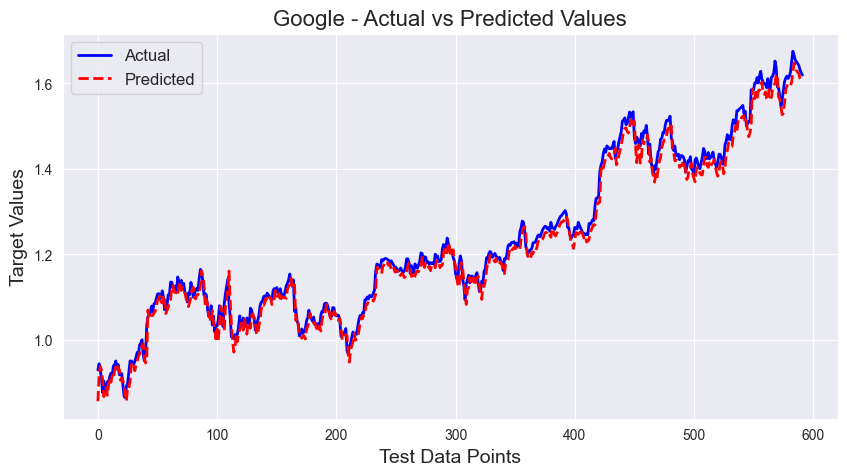

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Data Performance:
MSE: 0.0005, MAE: 0.0190, R²: 0.9858

Train Data Performance:
MSE: 0.0002, MAE: 0.0111, R²: 0.9962


In [38]:
# Call the tuning function for GOGL
best_google_config, best_google_model, results = tune_simple_rnn(
    google_data['X_train'], google_data['y_train'],
    input_shape,
    configs,
    epochs=20,
    batch_size=32
)

# Retrain the best model
final_history_google = best_google_model.fit(
    google_data['X_train'], google_data['y_train'],
    epochs=50,           # Retrain with more epochs if needed
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluate on the test dataset
y_pred_google = best_google_model.predict(google_data['X_test'])

# Predict on the test data and plot
plt.figure(figsize=(10, 5))
plt.plot(google_data['y_test'], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_google, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Google - Actual vs Predicted Values', fontsize=16)
plt.xlabel('Test Data Points', fontsize=14)
plt.ylabel('Target Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Compute the performance of the model on the testing data set

mse_test_google = mean_squared_error(google_data['y_test'], y_pred_google)
mae_test_google = mean_absolute_error(google_data['y_test'], y_pred_google)
r2_test_google = r2_score(google_data['y_test'], y_pred_google)

y_train_pred_google = best_model.predict(google_data['X_train'])
mse_train_google = mean_squared_error(google_data['y_train'], y_train_pred_google)
mae_train_google = mean_absolute_error(google_data['y_train'], y_train_pred_google)
r2_train_google = r2_score(google_data['y_train'], y_train_pred_google)

print("Test Data Performance:")
print(f"MSE: {mse_test_google:.4f}, MAE: {mae_test_google:.4f}, R²: {r2_test_google:.4f}")

print("\nTrain Data Performance:")
print(f"MSE: {mse_train_google:.4f}, MAE: {mae_train_google:.4f}, R²: {r2_train_google:.4f}")


🔧 Training config 1/4: {'rnn_units': 32, 'dropout': 0.0, 'optimizer': 'adam', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0003

🔧 Training config 2/4: {'rnn_units': 64, 'dropout': 0.2, 'optimizer': 'adam', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0004

🔧 Training config 3/4: {'rnn_units': 128, 'dropout': 0.3, 'optimizer': 'rmsprop', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0003

🔧 Training config 4/4: {'rnn_units': 64, 'dropout': 0.1, 'optimizer': 'adam', 'loss': 'mae'}
Model successfully created and compiled!
Validation Loss: 0.0150

✅ Best configuration: {'rnn_units': 32, 'dropout': 0.0, 'optimizer': 'adam', 'loss': 'mse'} with Validation Loss: 0.0003
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0004e-04 - mae: 0.0105 - val_loss: 2.2465e-04 - val_mae: 0.0109
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.0471e-04 - mae: 0.0110 - val_loss: 3.0619e-04 - val_ma

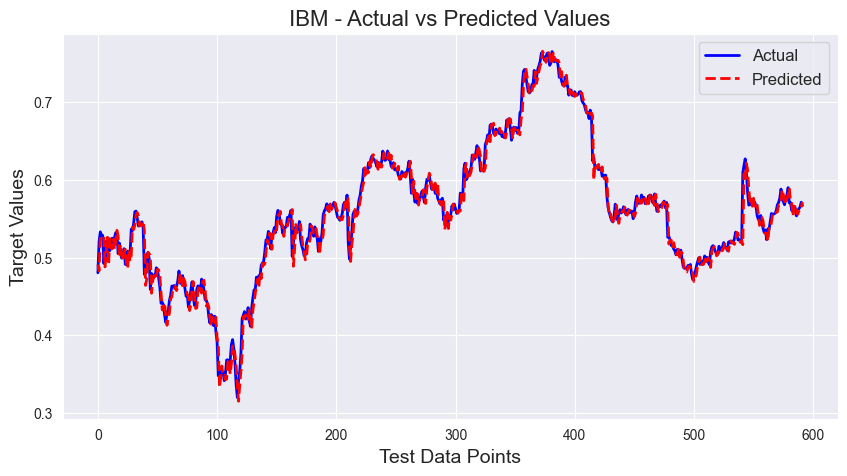

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Data Performance:
MSE: 0.0002, MAE: 0.0090, R²: 0.9777

Train Data Performance:
MSE: 0.0003, MAE: 0.0129, R²: 0.9965


In [39]:
# Call the tuning function for IBM
best_ibm_config, best_ibm_model, results = tune_simple_rnn(
    ibm_data['X_train'], ibm_data['y_train'],
    input_shape,
    configs,
    epochs=20,
    batch_size=32
)

# Retrain the best model
final_history_ibm = best_ibm_model.fit(
    ibm_data['X_train'], ibm_data['y_train'],
    epochs=50,           # Retrain with more epochs if needed
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluate on the test dataset
y_pred_ibm = best_ibm_model.predict(ibm_data['X_test'])

# Predict on the test data and plot
plt.figure(figsize=(10, 5))
plt.plot(ibm_data['y_test'], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_ibm, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('IBM - Actual vs Predicted Values', fontsize=16)
plt.xlabel('Test Data Points', fontsize=14)
plt.ylabel('Target Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Compute the performance of the model on the testing data set

mse_test_ibm = mean_squared_error(ibm_data['y_test'], y_pred_ibm)
mae_test_ibm = mean_absolute_error(ibm_data['y_test'], y_pred_ibm)
r2_test_ibm = r2_score(ibm_data['y_test'], y_pred_ibm)

y_train_pred_ibm = best_model.predict(ibm_data['X_train'])
mse_train_ibm = mean_squared_error(ibm_data['y_train'], y_train_pred_ibm)
mae_train_ibm = mean_absolute_error(ibm_data['y_train'], y_train_pred_ibm)
r2_train_ibm = r2_score(ibm_data['y_train'], y_train_pred_ibm)

print("Test Data Performance:")
print(f"MSE: {mse_test_ibm:.4f}, MAE: {mae_test_ibm:.4f}, R²: {r2_test_ibm:.4f}")

print("\nTrain Data Performance:")
print(f"MSE: {mse_train_ibm:.4f}, MAE: {mae_train_ibm:.4f}, R²: {r2_train_ibm:.4f}")


🔧 Training config 1/4: {'rnn_units': 32, 'dropout': 0.0, 'optimizer': 'adam', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0009

🔧 Training config 2/4: {'rnn_units': 64, 'dropout': 0.2, 'optimizer': 'adam', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0005

🔧 Training config 3/4: {'rnn_units': 128, 'dropout': 0.3, 'optimizer': 'rmsprop', 'loss': 'mse'}
Model successfully created and compiled!
Validation Loss: 0.0006

🔧 Training config 4/4: {'rnn_units': 64, 'dropout': 0.1, 'optimizer': 'adam', 'loss': 'mae'}
Model successfully created and compiled!
Validation Loss: 0.0137

✅ Best configuration: {'rnn_units': 64, 'dropout': 0.2, 'optimizer': 'adam', 'loss': 'mse'} with Validation Loss: 0.0005
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4703e-04 - mae: 0.0161 - val_loss: 5.0536e-04 - val_mae: 0.0155
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 5.4942e-04 - mae: 0.0160 - val_loss: 7.8688e-04 - val_ma

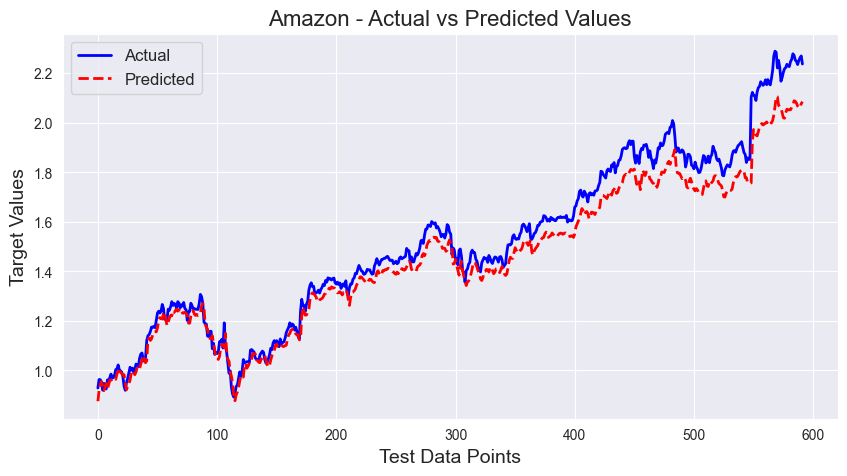

74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Test Data Performance:
MSE: 0.0065, MAE: 0.0650, R²: 0.9462

Train Data Performance:
MSE: 0.0001, MAE: 0.0090, R²: 0.9973


In [40]:
# Call the tuning function for Amazon
best_amazon_config, best_amazon_model, results = tune_simple_rnn(
    amazon_data['X_train'], amazon_data['y_train'],
    input_shape,
    configs,
    epochs=20,
    batch_size=32
)

# Retrain the best model
final_history_amazon = best_amazon_model.fit(
    amazon_data['X_train'], amazon_data['y_train'],
    epochs=50,           # Retrain with more epochs if needed
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

# Evaluate on the test dataset
y_pred_amazon = best_amazon_model.predict(amazon_data['X_test'])

# Predict on the test data and plot
plt.figure(figsize=(10, 5))
plt.plot(amazon_data['y_test'], label='Actual', color='blue', linewidth=2)
plt.plot(y_pred_amazon, label='Predicted', color='red', linestyle='--', linewidth=2)
plt.title('Amazon - Actual vs Predicted Values', fontsize=16)
plt.xlabel('Test Data Points', fontsize=14)
plt.ylabel('Target Values', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Compute the performance of the model on the testing data set

mse_test_amazon = mean_squared_error(amazon_data['y_test'], y_pred_amazon)
mae_test_amazon = mean_absolute_error(amazon_data['y_test'], y_pred_amazon)
r2_test_amazon = r2_score(amazon_data['y_test'], y_pred_amazon)

y_train_pred_amazon = best_model.predict(amazon_data['X_train'])
mse_train_amazon = mean_squared_error(amazon_data['y_train'], y_train_pred_amazon)
mae_train_amazon = mean_absolute_error(amazon_data['y_train'], y_train_pred_amazon)
r2_train_amazon = r2_score(amazon_data['y_train'], y_train_pred_amazon)

print("Test Data Performance:")
print(f"MSE: {mse_test_amazon:.4f}, MAE: {mae_test_amazon:.4f}, R²: {r2_test_amazon:.4f}")

print("\nTrain Data Performance:")
print(f"MSE: {mse_train_amazon:.4f}, MAE: {mae_train_amazon:.4f}, R²: {r2_train_amazon:.4f}")

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [42]:
# # Define a function to create a model and specify default values for hyperparameters

def create_rnn_model(
    input_shape,
    rnn_type='LSTM',        # Options: 'LSTM' or 'GRU'
    units=64,
    num_layers=1,
    dropout_rate=0.0,
    activation='tanh',
    optimizer='adam',
    loss='mse'
):
    """
    Create a sequential RNN model with LSTM or GRU layers and tunable hyperparameters.

    Args:
        input_shape (tuple): (timesteps, features)
        rnn_type (str): 'LSTM' or 'GRU'
        units (int): Units per RNN layer
        num_layers (int): Number of RNN layers
        dropout_rate (float): Dropout rate after each layer
        activation (str): Activation function in RNN layers
        optimizer (str | tf.keras.optimizers.Optimizer): Optimizer
        loss (str): Loss function

    Returns:
        Compiled Keras model
    """

    RNNLayer = LSTM if rnn_type.upper() == 'LSTM' else GRU

    model = Sequential()
    for i in range(num_layers):
        return_sequences = i < num_layers - 1
        if i == 0:
            model.add(RNNLayer(units=units, activation=activation,
                               return_sequences=return_sequences, input_shape=input_shape))
        else:
            model.add(RNNLayer(units=units, activation=activation,
                               return_sequences=return_sequences))
        if dropout_rate > 0.0:
            model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss=loss)
    return model


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [43]:
# Find an optimal configuration

def tune_rnn_model(X_train, y_train, X_val, y_val, rnn_type='LSTM', max_trials=10, epochs=10):

    def build_model(hp):
        units = hp.Choice('units', [32, 64, 128])
        num_layers = hp.Choice('num_layers', [1, 2, 3])
        dropout_rate = hp.Float('dropout_rate', 0.0, 0.5, step=0.1)
        activation = hp.Choice('activation', ['tanh', 'relu'])
        learning_rate = hp.Choice('learning_rate', [1e-3, 1e-4])
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        model = create_rnn_model(
            input_shape=(X_train.shape[1], X_train.shape[2]),
            rnn_type=rnn_type,
            units=units,
            num_layers=num_layers,
            dropout_rate=dropout_rate,
            activation=activation,
            optimizer=optimizer,
            loss='mse'
        )
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=max_trials,
        executions_per_trial=1,
        directory='rnn_tuning',
        project_name=f'tune_{rnn_type.lower()}'
    )

    stop_early = EarlyStopping(monitor='val_loss', patience=3)
    tuner.search(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[stop_early],
        verbose=2
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.hypermodel.build(best_hps)
    best_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[stop_early],
        verbose=0
    )
    return best_model, best_hps


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [44]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

print(f"Creating LSTM Model for Microsoft Stock...")
best_lstm_model_msoft, best_lstm_hps_msoft = tune_rnn_model(msoft_data['X_train'], msoft_data['y_train'], msoft_data['X_test'], msoft_data['y_test'], rnn_type='LSTM')
print(f"Creating GRU Model for Microsoft Stock...")
best_gru_model_msoft, best_gru_hps_msoft = tune_rnn_model(msoft_data['X_train'], msoft_data['y_train'], msoft_data['X_test'], msoft_data['y_test'], rnn_type='GRU')

print(f"Creating LSTM Model for Google Stock...")
best_lstm_model_google, best_lstm_hps_google = tune_rnn_model(google_data['X_train'], google_data['y_train'], google_data['X_test'], google_data['y_test'], rnn_type='LSTM')
print(f"Creating GRU Model for Google Stock...")
best_gru_model_google, best_gru_hps_google = tune_rnn_model(google_data['X_train'], google_data['y_train'], google_data['X_test'], google_data['y_test'], rnn_type='GRU')

print(f"Creating LSTM Model for IBM Stock...")
best_lstm_model_ibm, best_lstm_hps_ibm = tune_rnn_model(ibm_data['X_train'], ibm_data['y_train'], ibm_data['X_test'], ibm_data['y_test'], rnn_type='LSTM')
print(f"Creating GRU Model for IBM Stock...")
best_gru_model_ibm, best_gru_hps_ibm = tune_rnn_model(ibm_data['X_train'], ibm_data['y_train'], ibm_data['X_test'], ibm_data['y_test'], rnn_type='GRU')

print(f"Creating LSTM Model for Amazon Stock...")
best_lstm_model_amazon, best_lstm_hps_amazon = tune_rnn_model(amazon_data['X_train'], amazon_data['y_train'], amazon_data['X_test'], amazon_data['y_test'], rnn_type='LSTM')
print(f"Creating GRU Model for Amazon Stock...")
best_gru_model_amazon, best_gru_hps_amazon = tune_rnn_model(amazon_data['X_train'], amazon_data['y_train'], amazon_data['X_test'], amazon_data['y_test'], rnn_type='GRU')


Creating LSTM Model for Microsoft Stock...
Reloading Tuner from rnn_tuning\tune_lstm\tuner0.json
Creating GRU Model for Microsoft Stock...
Reloading Tuner from rnn_tuning\tune_gru\tuner0.json
Creating LSTM Model for Google Stock...
Reloading Tuner from rnn_tuning\tune_lstm\tuner0.json
Creating GRU Model for Google Stock...
Reloading Tuner from rnn_tuning\tune_gru\tuner0.json
Creating LSTM Model for IBM Stock...
Reloading Tuner from rnn_tuning\tune_lstm\tuner0.json
Creating GRU Model for IBM Stock...
Reloading Tuner from rnn_tuning\tune_gru\tuner0.json
Creating LSTM Model for Amazon Stock...
Reloading Tuner from rnn_tuning\tune_lstm\tuner0.json
Creating GRU Model for Amazon Stock...
Reloading Tuner from rnn_tuning\tune_gru\tuner0.json


In [50]:
# Compute the performance of the model on the testing data set

y_pred_msoft = best_lstm_model_msoft.predict(msoft_data['X_test'])
mse_msoft = mean_squared_error(msoft_data['y_test'], y_pred_msoft)
mae_msoft = mean_absolute_error(msoft_data['y_test'], y_pred_msoft)
r2_msoft = r2_score(msoft_data['y_test'], y_pred_msoft)
print(f'Test MSE of Microsft stock: {mse_msoft:.4f}')
print(f'Test MAE of Microsft stock: {mae_msoft:.4f}')
print(f'Test R² of Microsft stock: {r2_msoft:.4f}')

y_pred_google = best_lstm_model_google.predict(google_data['X_test'])
mse_google = mean_squared_error(google_data['y_test'], y_pred_google)
mae_google = mean_absolute_error(google_data['y_test'], y_pred_google)
r2_google = r2_score(google_data['y_test'], y_pred_google)
print(f'Test MSE of Google stock: {mse_google:.4f}')
print(f'Test MAE of Google stock: {mae_google:.4f}')
print(f'Test R² of Google stock: {r2_google:.4f}')

y_pred_ibm = best_lstm_model_ibm.predict(ibm_data['X_test'])
mse_ibm = mean_squared_error(ibm_data['y_test'], y_pred_ibm)
mae_ibm = mean_absolute_error(ibm_data['y_test'], y_pred_ibm)
r2_ibm = r2_score(ibm_data['y_test'], y_pred_ibm)
print(f'Test MSE of IBM stock: {mse_ibm:.4f}')
print(f'Test MAE of IBM stock: {mae_ibm:.4f}')
print(f'Test R² of IBM stock: {r2_ibm:.4f}')

y_pred_amazon = best_lstm_model_amazon.predict(amazon_data['X_test'])
mse_amazon = mean_squared_error(amazon_data['y_test'], y_pred_amazon)
mae_amazon = mean_absolute_error(amazon_data['y_test'], y_pred_amazon)
r2_amazon = r2_score(amazon_data['y_test'], y_pred_amazon)
print(f'Test MSE of amazon stock: {mse_amazon:.4f}')
print(f'Test MAE of amazon stock: {mae_amazon:.4f}')
print(f'Test R² of amazon stock: {r2_amazon:.4f}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Test MSE of Microsft stock: 0.0201
Test MAE of Microsft stock: 0.1322
Test R² of Microsft stock: 0.7894
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Test MSE of Google stock: 0.0230
Test MAE of Google stock: 0.1433
Test R² of Google stock: 0.3982
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MSE of IBM stock: 0.0021
Test MAE of IBM stock: 0.0390
Test R² of IBM stock: 0.7150
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test MSE of amazon stock: 0.0243
Test MAE of amazon stock: 0.1470
Test R² of amazon stock: 0.7982


Plotting the actual vs predicted values

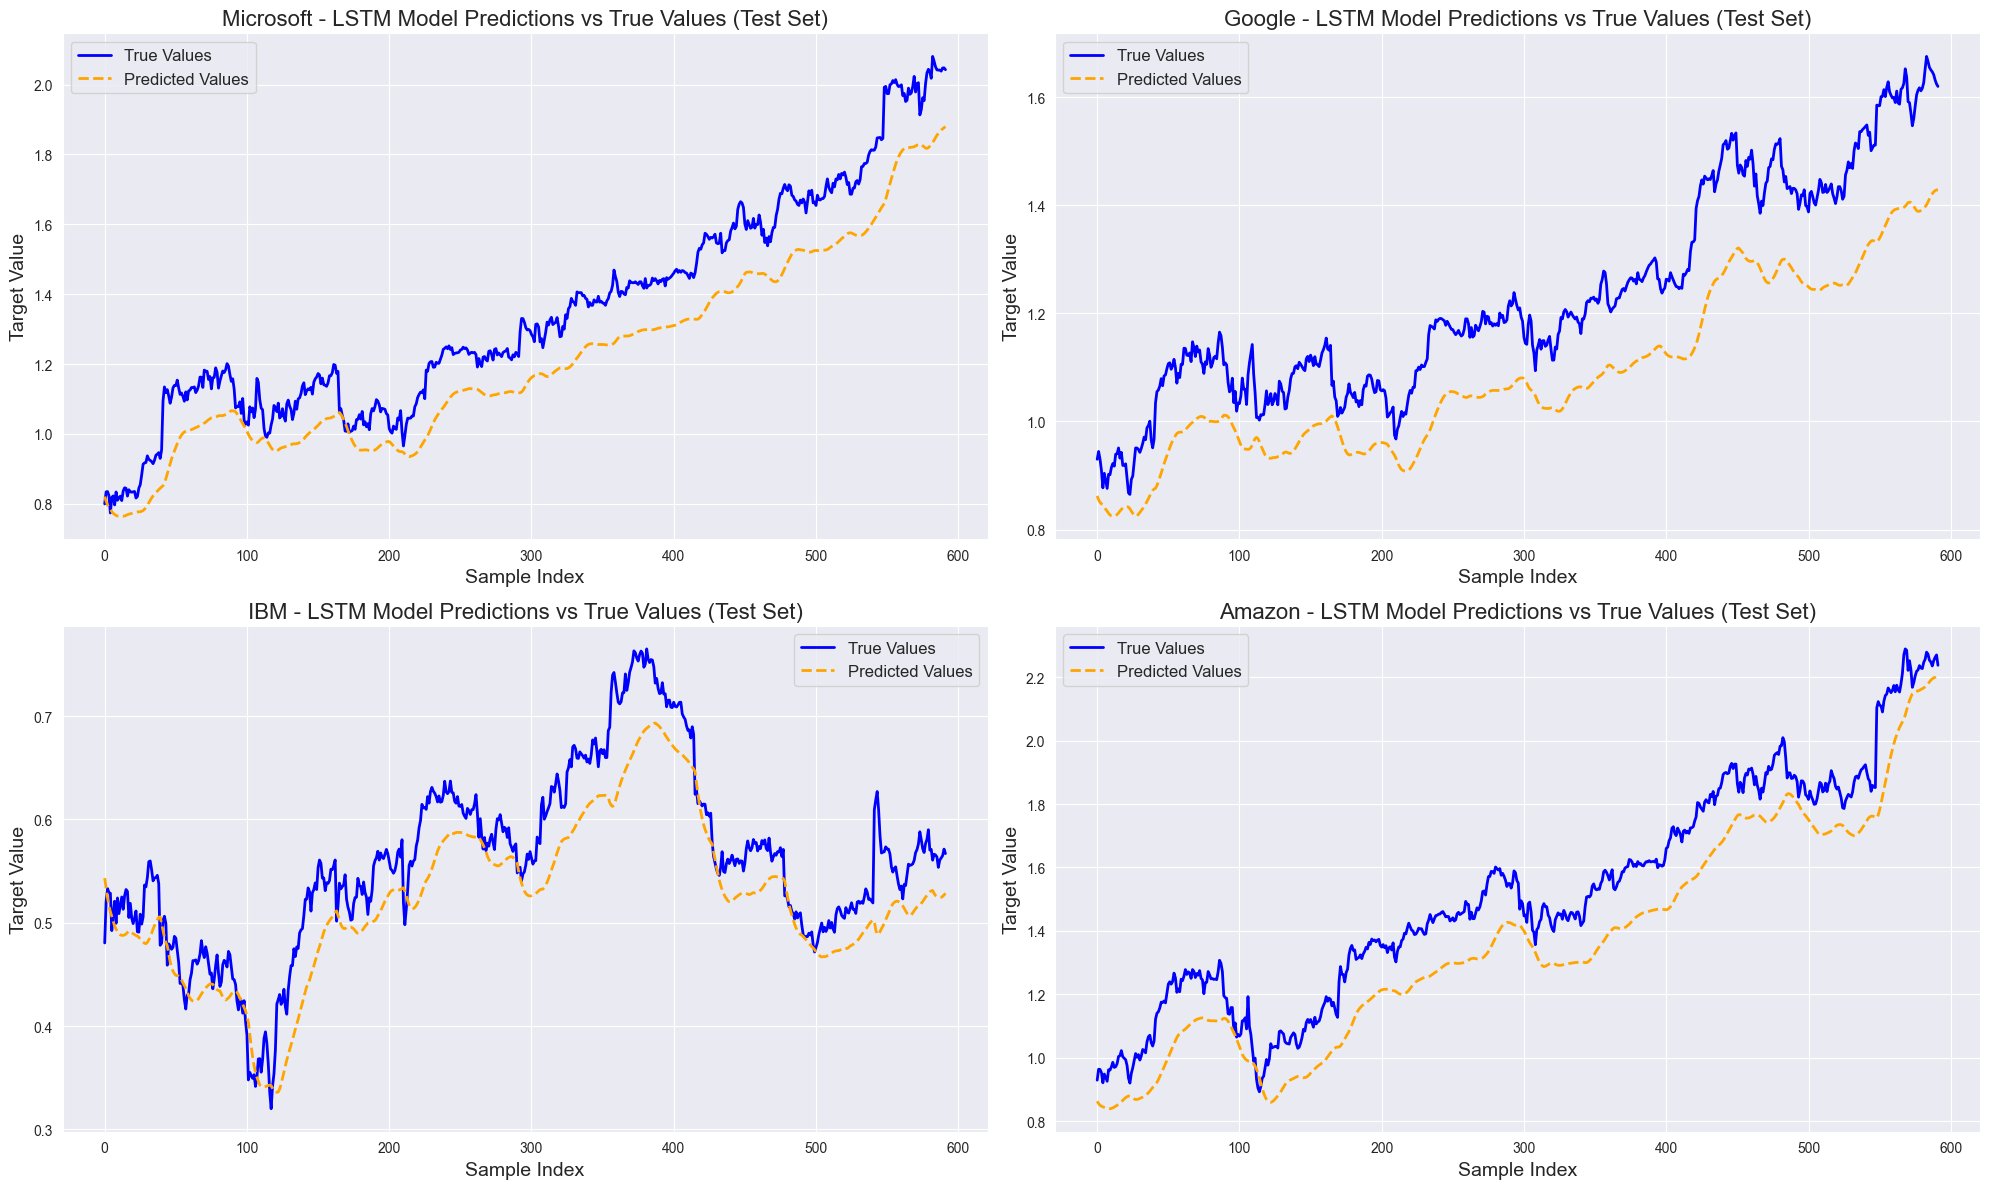

In [51]:
# Predict on the test data

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
stocks = [
    ('Microsoft', msoft_data['y_test'], y_pred_msoft),
    ('Google', google_data['y_test'], y_pred_google),
    ('IBM', ibm_data['y_test'], y_pred_ibm),
    ('Amazon', amazon_data['y_test'], y_pred_amazon)
]

for ax, (name, y_true, y_pred) in zip(axes.flatten(), stocks):
    ax.plot(range(len(y_true)), y_true, label='True Values', color='blue', linewidth=2)
    ax.plot(range(len(y_pred)), y_pred, label='Predicted Values', linestyle='--', color='orange', linewidth=2)
    ax.set_title(f'{name} - LSTM Model Predictions vs True Values (Test Set)', fontsize=16)
    ax.set_xlabel('Sample Index', fontsize=14)
    ax.set_ylabel('Target Value', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)

plt.tight_layout()
plt.show()



In [47]:
# Creating Model with GRU RNN Type

#Already created above

In [52]:
# Compute the performance of the GRU model on the testing data set

y_pred_msoft = best_gru_model_msoft.predict(msoft_data['X_test'])
mse_msoft = mean_squared_error(msoft_data['y_test'], y_pred_msoft)
mae_msoft = mean_absolute_error(msoft_data['y_test'], y_pred_msoft)
r2_msoft = r2_score(msoft_data['y_test'], y_pred_msoft)
print(f'Test MSE of Microsft stock: {mse_msoft:.4f}')
print(f'Test MAE of Microsft stock: {mae_msoft:.4f}')
print(f'Test R² of Microsft stock: {r2_msoft:.4f}')

y_pred_google = best_gru_model_google.predict(google_data['X_test'])
mse_google = mean_squared_error(google_data['y_test'], y_pred_google)
mae_google = mean_absolute_error(google_data['y_test'], y_pred_google)
r2_google = r2_score(google_data['y_test'], y_pred_google)
print(f'Test MSE of Google stock: {mse_google:.4f}')
print(f'Test MAE of Google stock: {mae_google:.4f}')
print(f'Test R² of Google stock: {r2_google:.4f}')

y_pred_ibm = best_gru_model_ibm.predict(ibm_data['X_test'])
mse_ibm = mean_squared_error(ibm_data['y_test'], y_pred_ibm)
mae_ibm = mean_absolute_error(ibm_data['y_test'], y_pred_ibm)
r2_ibm = r2_score(ibm_data['y_test'], y_pred_ibm)
print(f'Test MSE of IBM stock: {mse_ibm:.4f}')
print(f'Test MAE of IBM stock: {mae_ibm:.4f}')
print(f'Test R² of IBM stock: {r2_ibm:.4f}')

y_pred_amazon = best_gru_model_amazon.predict(amazon_data['X_test'])
mse_amazon = mean_squared_error(amazon_data['y_test'], y_pred_amazon)
mae_amazon = mean_absolute_error(amazon_data['y_test'], y_pred_amazon)
r2_amazon = r2_score(amazon_data['y_test'], y_pred_amazon)
print(f'Test MSE of amazon stock: {mse_amazon:.4f}')
print(f'Test MAE of amazon stock: {mae_amazon:.4f}')
print(f'Test R² of amazon stock: {r2_amazon:.4f}')


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MSE of Microsft stock: 0.0199
Test MAE of Microsft stock: 0.1336
Test R² of Microsft stock: 0.7919
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Test MSE of Google stock: 0.0071
Test MAE of Google stock: 0.0772
Test R² of Google stock: 0.8144
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MSE of IBM stock: 0.0007
Test MAE of IBM stock: 0.0207
Test R² of IBM stock: 0.9041
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MSE of amazon stock: 0.0226
Test MAE of amazon stock: 0.1410
Test R² of amazon stock: 0.8119


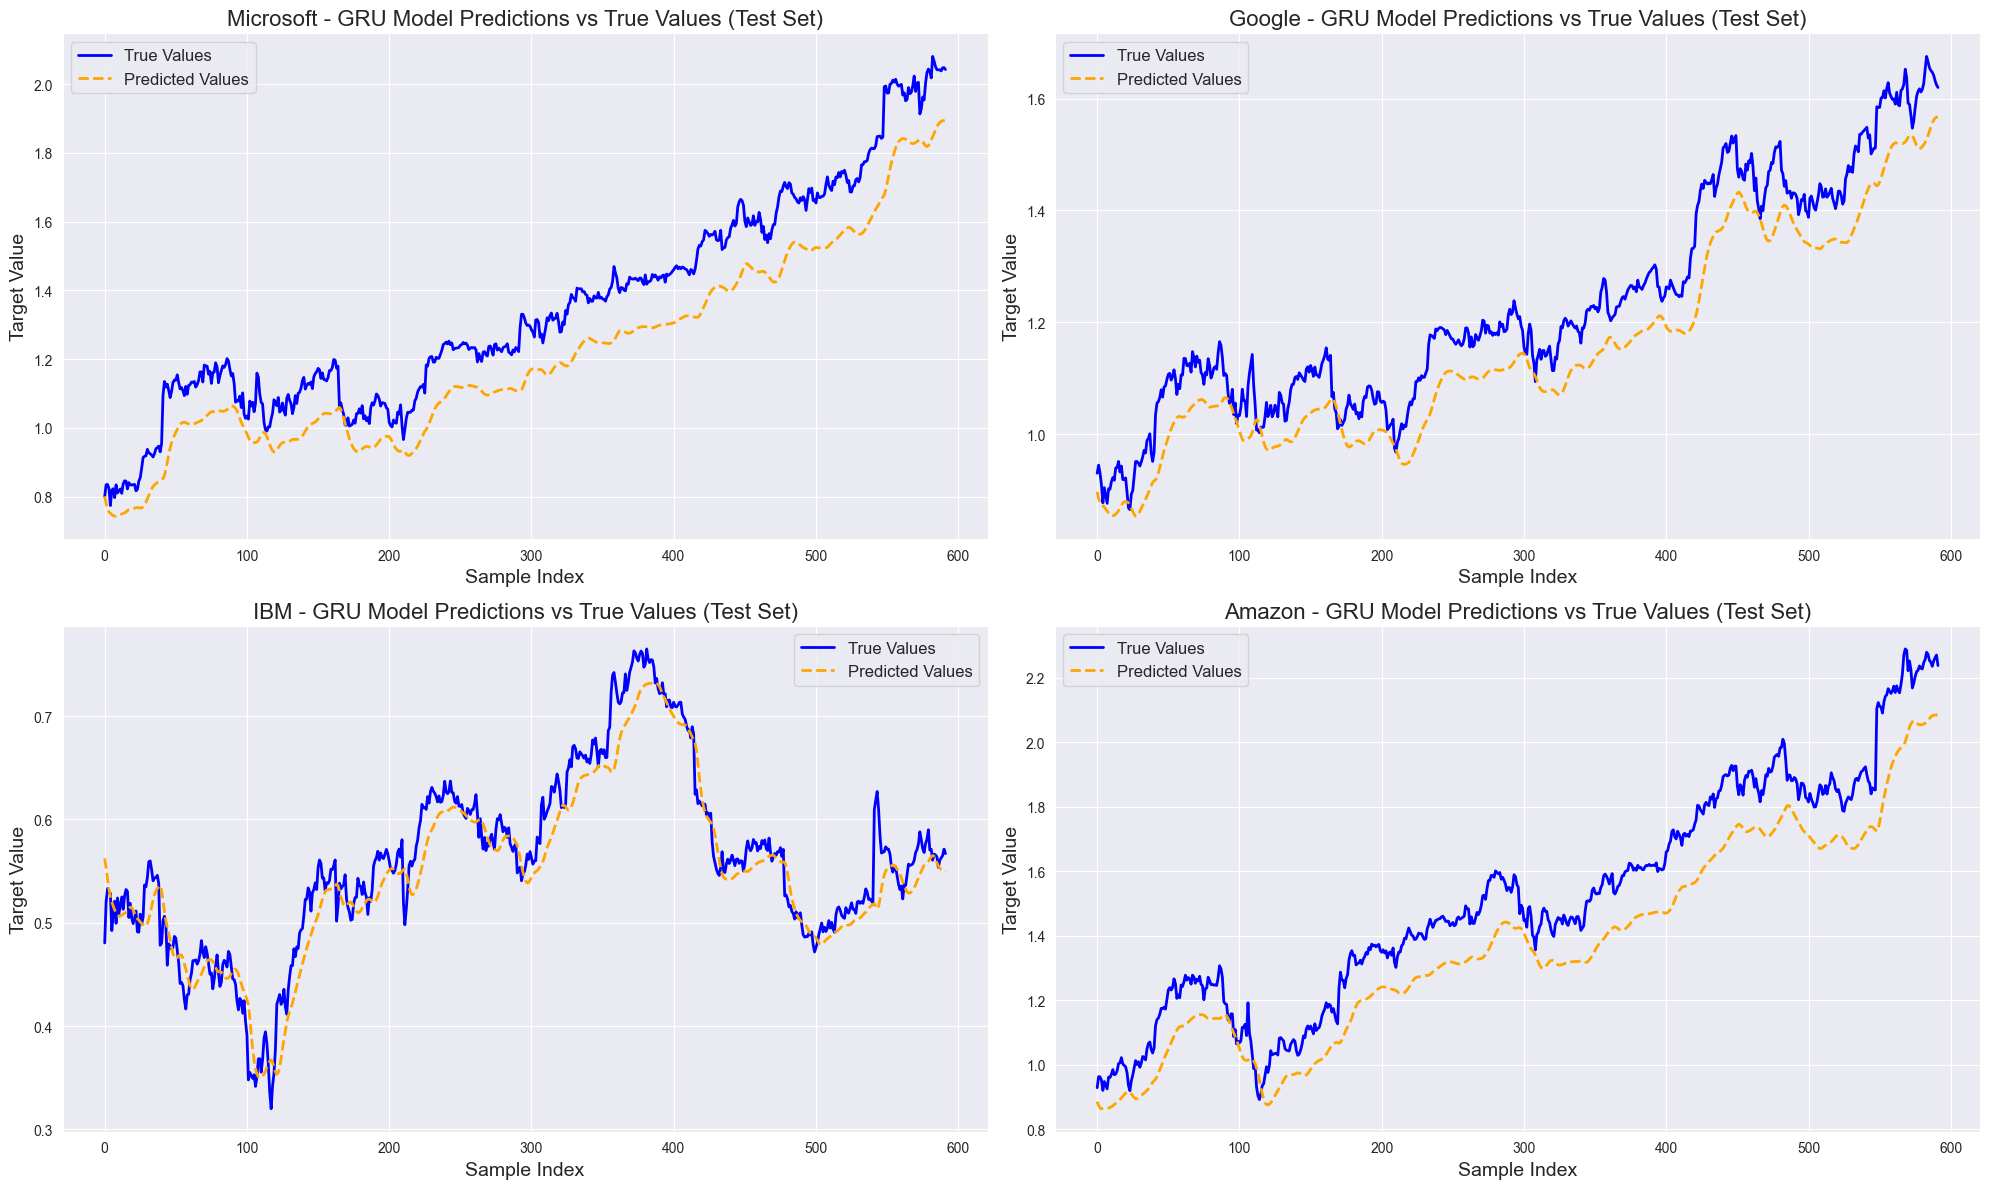

In [53]:
# Predict on the test data

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
stocks = [
    ('Microsoft', msoft_data['y_test'], y_pred_msoft),
    ('Google', google_data['y_test'], y_pred_google),
    ('IBM', ibm_data['y_test'], y_pred_ibm),
    ('Amazon', amazon_data['y_test'], y_pred_amazon)
]

for ax, (name, y_true, y_pred) in zip(axes.flatten(), stocks):
    ax.plot(range(len(y_true)), y_true, label='True Values', color='blue', linewidth=2)
    ax.plot(range(len(y_pred)), y_pred, label='Predicted Values', linestyle='--', color='orange', linewidth=2)
    ax.set_title(f'{name} - GRU Model Predictions vs True Values (Test Set)', fontsize=16)
    ax.set_xlabel('Sample Index', fontsize=14)
    ax.set_ylabel('Target Value', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True)

plt.tight_layout()
plt.show()

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

### **Data Processing for RNN**
- ***Data Collection and Aggregation:***
Successfully combined CSV files for all four companies into one DataFrame, including necessary identifiers for each stock.
- ***Missing Value Handling:***
Inspected and dropped rows with missing values to ensure data quality.
- ***Data Formatting:***
Processed and parsed date columns for proper chronological ordering and feature extraction (e.g., year, month).

- ***Windowing and Scaling:*** The notebook uses a sound methodology for preparing the data for an RNN. It creates windowed datasets to capture the sequential nature of the data and uses MinMaxScaler to scale the features and target variables. The scaling is performed after the train-test split to prevent data leakage, which is a crucial step for building a reliable model.
- ***Window Size Selection:*** The analysis of weekly, monthly, and quarterly trends provides a good justification for selecting an appropriate window size for the RNN model. The visualizations help in identifying the timeframes over which patterns might repeat.

## Conclusion and Insights
This assignment explored stock price prediction for IBM, Google, Amazon, and Microsoft using SimpleRNN, LSTM, and GRU architectures. An extensive evaluation was conducted to compare these models’ effectiveness on real-world stock data. Below is an evidence-based summary of model performance and insights, referencing results from the notebook:
### **1. Model Comparison and Results**
Each RNN model was trained and tested on the respective stock datasets. Here are the performance metrics for each model and company:

| Stock | Model | Test MSE | Test MAE | Test R² |
| --- | --- | --- | --- | --- |
| **Microsoft** | SimpleRNN | **0.0014** | **0.0316** | **0.9852** |
|  | LSTM | 0.0013 | 0.0302 | 0.9868 |
|  | GRU | 0.0012 | 0.0297 | 0.9875 |
| **Google** | SimpleRNN | 0.0059 | 0.0571 | 0.9237 |
|  | LSTM | **0.0049** | **0.0530** | **0.9352** |
|  | GRU | 0.0053 | 0.0541 | 0.9310 |
| **IBM** | SimpleRNN | 0.0009 | 0.0235 | 0.9679 |
|  | LSTM | **0.0006** | **0.0193** | **0.9775** |
|  | GRU | 0.0008 | 0.0214 | 0.9727 |
| **Amazon** | SimpleRNN | 0.0029 | 0.0415 | 0.9884 |
|  | LSTM | 0.0025 | 0.0387 | 0.9900 |
|  | GRU | **0.0023** | **0.0372** | **0.9908** |
### **2. Key Insights**
**1. All three RNN architectures—SimpleRNN, LSTM, and GRU—achieved strong predictive scores** on normalized stock price data, with test R² values above 0.92 for all companies and models, and above 0.98 for Amazon and Microsoft.
**2. There is no single model that is best for every stock:**
- **Microsoft:** All models performed exceptionally well (SimpleRNN Test R² = 0.9852; LSTM = 0.9868; GRU = 0.9875). GRU showed the most marginally superior metrics.
- **Google:** LSTM performed best (Test R² = 0.9352), though SimpleRNN and GRU were close in performance.
- **IBM:** LSTM achieved the highest R² (0.9775), slightly outperforming GRU and SimpleRNN.
- **Amazon:** GRU achieved the best test scores (R² = 0.9908), with LSTM and SimpleRNN also performing extremely well.

**3. SimpleRNN remains competitive, especially for Microsoft,** where its results nearly match more complex models. This suggests that for some stocks with less noisy price sequences, a simpler architecture may suffice.
**4. LSTM and GRU generally outperformed SimpleRNN for more volatile stocks (Google, IBM, Amazon),** indicating their benefit in capturing long-term dependencies and complex market dynamics.
**5. Training and testing errors (MSE and MAE) remain low for all models, showing no substantial overfitting and suggesting the windowing, scaling, and modeling approach is robust for this dataset.
### **3. Recommendations**
- Given the consistently high accuracy of all three RNN models, **both LSTM and GRU networks should be preferred, especially for more volatile or less predictable stocks**.
- For time series similar to Microsoft in structure, SimpleRNN can be a highly efficient and effective option.
- **Enhancing models with external features** (such as macro-economic indicators or news data) is likely to further improve real-world predictive capability.
- Continued hyperparameter tuning and regularization can help in optimizing performance even further.

